<a href="https://colab.research.google.com/github/donghuna/AI-Expert/blob/main/%ED%99%A9%EC%8A%B9%EC%9B%90/%5BStudent%5DOllama%2BLangChain_for_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced IR

## Improve TF-IDF: BM25, Lucene

앞선 TF-IDF에서는 단어가 문서에 나타나는 빈도, 해당 단어가 몇개의 문서에 나타나는지에 따라 질의에 관련있는 문서를 가져오는 방법을 구현해보았습니다.

$$ \text{TF-IDF}(t, d, D) = \frac{f_{t,d}}{N_d} \times \log \left( \frac{N}{n_t} \right) $$

하지만 TF-IDF에는 3가지 문제점이 있습니다.
1. 관련 단어가 문서에서 많이 언급되면 될수록 TF 점수가 계속 오릅니다.
2. IDF의 영향력이 작습니다. 그렇다보니 불용어의 영향력이 여전히 살아있습니다. (그래서 이전에는 불용어를 전처리해서 없애기도 했습니다.)
3. 문서의 길이의 영향이 큽니다. 문서의 길이가 길면 점수가 큰 폭으로 줄어듭니다.

이런 문제점을 해결하기 위해 BM25 (Lucene on ElasticSEarch)가 등장했습니다.

$$ \text{BM25}(d, q) = \sum_{t \in q} IDF(t) \cdot \frac{f(t,d) \cdot (k_1 + 1)}{f(t,d) + k_1 \cdot \left(1 - b + b \cdot \frac{|d|}{\text{avgdl}}\right)} $$

BM25의 수식을 가만히 보면 TF-IDF와 많은 부분이 겹칩니다. 네! BM25는 TF-IDF의 수식의 변형입니다.

수식을 가만히 보면 앞서 말한 문제를 해결하려는 시도를 볼 수 있습니다.

TF의 영향을 줄이기 위해 정규화된 수식을 볼 수 있습니다.

freq / (freq + k1 * (1 - b + b * dl / avgdl))

또한, 길이의 영향을 덜 받기 위해 길이로 나눈 모습을 볼 수 있습니다.

이렇듯, BM25는 TF-IDF를 확장한 형태로 관련도 점수를 계산합니다.

수식이 간단하고 계산 복잡도가 낮아 요즘에도 이를 기반으로 검색 엔진을 많이 구축합니다.

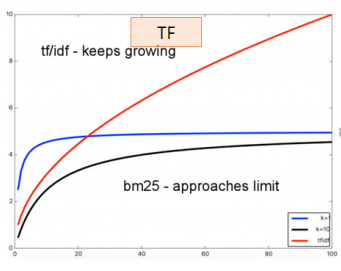

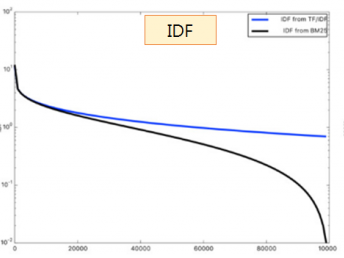

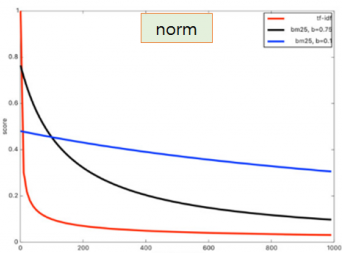

## ElasticSearch
직접 BM25를 구현하는 것은 다소 번거롭기 때문에 elasticsearch를 이용하는 방법을 사용해보겠습니다.

elastic-search는 소규모로 사용하는 경우 무료로 사용할 수 있습니다.

(https://github.com/deviantony/docker-elk)

도커로 elastic search를 띄워볼 수 있습니다.

실습에서는 미리 만들어둔 인덱스를 사용해보겠습니다.


### index 생성
BM25 수식의 분모 부분은 미리 계산 해둘 수 있습니다. 이는 해당 수식이 문서에만 한정되어 있기 때문입니다.

이 부분을 계산해서 저장해두는 것을 index를 저장한다고 합니다.

elastic search에 index를 저장할 공간을 다음과 같이 생성해 볼 수 있습니다.

~~~python
from elasticsearch import Elasticsearch

with Elasticsearch(
        "http://elasticsearch:9200",
        api_key="xxxxxxx"
    ) as client:
    client.indices.create(
            index=f"index_name",
            body={
                "mappings": {
                    "properties": {
                        "did": {
                            "type": "text",
                            "index": False
                        },
                        "title": {
                            "type": "text",
                            "index": False
                        },
                        "text": {
                            "type": "text",
                            "index": False
                        },
                        "embedding": {
                            "type": "dense_vector",
                            "dims": 4096,
                            "index": True,
                            "similarity": "dot_product"  # l2_norm, cosine, max_inner_product
                        }
                    }
                }
            }
        )
      
~~~

### 검색 하기

In [ ]:
!pip install -q elasticsearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.2/480.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 1.4 MB/s eta 0:00:00


In [ ]:
from elasticsearch import Elasticsearch
from pprint import pprint

with Elasticsearch(
        "http://ldi.snu.ac.kr:19200",
        api_key="eXFLak9KQUJHT0psR0xXalF3VFk6QWd4cl85SzZTa1N5dnkxcE1aaGM5QQ=="
    ) as client:
    response = client.search(
                index="dashboard-papers",
                body={
                    "query": {
                        "query_string": {
                            "query": "query expansion"
                        }
                    }
                }
            )

pprint(response["hits"])

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_transport.py", line 342, in perform_request
    resp = node.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_node/_http_urllib3.py", line 202, in perform_request
    raise err from None
elastic_transport.ConnectionError: Connection error caused by: ProtocolError(('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')))


{'hits': [{'_id': 'RE3jSpABQi2pKE2hZ3S1',
           '_ignored': ['abstract.keyword',
                        'discussions.keyword',
                        'contributions.keyword',
                        'summary.keyword',
                        'methodology.keyword',
                        'tldr.keyword',
                        'results.keyword'],
           '_index': 'dashboard-papers',
           '_score': 19.02616,
           '_source': {'abstract': 'Using large language models (LMs) for '
                                   'query or document expansion can improve '
                                   'generalization in information retrieval. '
                                   'However, it is unknown whether these '
                                   'techniques are universally beneficial or '
                                   'only effective in specific settings, such '
                                   'as for particular retrieval models, '
                               

## Expand IR to Vector level

지금까지는 검색을 단어 단위로 토크나이징해서 모델링을 했습니다.

이 방식은 빠르고 성능이 좋지만 문장의 문맥을 잊기 때문에 강력하지는 않습니다.

앞선 수업에서 배운 BERT 즉, 트랜스포머를 활용한 검색모델들이 이런 문제를 해결합니다.

문장 전체 맥락을 담아 벡터로 표현합니다. 이제 더 이상 단어로 나눠가며 vocabulary로 표현하지 않고 해당 문서가 전반적으로 어떤 정보를 담고 있는 지 숫자로 표현합니다.

#### Get Example vector
숨겨진 셀에는 4096개의 소수를 담은 리스트가 있습니다.

매우 길기 때문에 열지 않는 걸 추천드립니다. 브라우저가 멈출 수 있습니다.

In [ ]:
query = "Do cholesterol statin drugs cause breast cancer?"
query_vec = [0.00519033707678318, 0.012766138650476933, -0.006307477131485939, -0.006765618454664946, 0.003939977381378412, 0.015640687197446823, -0.01007435005158186, -0.004221309907734394, 0.0030176201835274696, 0.012022820301353931, 0.014615442603826523, -0.0047317673452198505, -0.008497294969856739, 0.006930317264050245, -0.019927963614463806, 0.0060900854878127575, 0.020526433363556862, 0.004428989719599485, -0.027215521782636642, 0.022007957100868225, 0.005703956354409456, 0.013568218797445297, 0.008022296242415905, 0.014843122102320194, 0.0005984313320368528, 0.003307440783828497, 0.0010203104466199875, 0.0014038921799510717, -0.013556737452745438, 0.013630244880914688, 0.014789682812988758, -0.01801621913909912, -0.0038278549909591675, -0.0039017063099890947, 0.0013031014241278172, 0.0035360020119696856, -0.008104470558464527, 0.01165094692260027, -0.008962028659880161, -0.017036503180861473, 0.021623937413096428, 0.019584065303206444, 0.008799688890576363, -0.021652691066265106, -0.0050700572319328785, -0.011789060197770596, 0.006960194557905197, -0.01756405271589756, 0.019520657137036324, -0.00607718899846077, 0.026601893827319145, -0.00041903226519934833, 0.005752188619226217, -0.0010483410442247987, -0.004874521400779486, 0.022292397916316986, -0.005671252496540546, 0.007095110137015581, -0.015475458465516567, 0.017217068001627922, 0.010495740920305252, 0.0007267352775670588, -0.005322738084942102, 0.01422587875276804, 0.020722683519124985, 0.005927491933107376, 0.009866156615316868, 0.0076531763188540936, -0.00824510958045721, -0.007172783371061087, 0.013492257334291935, 0.02185547910630703, -0.017579156905412674, 0.008833885192871094, -0.006288252305239439, 0.002519847359508276, 0.013269075192511082, 0.0037314791698008776, -0.0016052672872319818, -0.016617009416222572, -0.023434022441506386, -0.0072767287492752075, -0.0006272646132856607, -0.016821132972836494, 0.00689291674643755, -0.0004257828986737877, 0.006404020823538303, -0.010102611035108566, 0.012182528153061867, 0.013221584260463715, 0.005632027052342892, -0.03050810471177101, -0.0007036376046016812, -0.008884142152965069, -0.008718892000615597, 0.010122069157660007, -0.005961104761809111, -0.004046472255140543, -0.0019441678887233138, 0.0021246112883090973, 0.004712681286036968, -0.020568739622831345, 0.014246751554310322, -0.0073846485465765, 0.012554281391203403, -0.0012348650489002466, 0.009244773536920547, -0.005365318618714809, -0.0020954732317477465, 0.018314167857170105, -0.006122614722698927, -0.009924039244651794, 0.02591652236878872, -0.00963339302688837, 0.0020522112026810646, 0.008876428939402103, -0.0036944972816854715, 0.0039673917926847935, -0.0036407073494046926, -0.001337213907390833, -0.003558553522452712, 0.0015128226950764656, -0.005384780932217836, 0.011382583528757095, 0.02999834343791008, 0.0013471636921167374, 0.011633658781647682, -0.015492775477468967, -0.028283042833209038, 0.011216885410249233, 0.008645388297736645, 0.012206393294036388, -0.006854421924799681, -0.003877644194290042, 0.005943648051470518, 0.0005583981983363628, 0.00012796124792657793, -0.004845468793064356, 0.020560337230563164, -0.0031996143516153097, 0.004991260357201099, 0.004613043740391731, -0.0006285209092311561, -0.009585326537489891, -0.006514993030577898, 0.012771528214216232, -0.01653306558728218, -0.021485911682248116, 0.019487610086798668, 0.05629104748368263, 0.004136719275265932, -0.017153047025203705, 0.0058784750290215015, -0.0028619051445275545, -0.005783165339380503, 0.008879170753061771, -0.034990936517715454, 0.014150353148579597, 0.01663496531546116, 0.015497827902436256, -0.0047974311746656895, -0.004169232677668333, -0.00025264883879572153, 0.017525555565953255, -0.00202645780518651, -0.019203104078769684, -0.0034610882867127657, -0.005597782786935568, 0.0005429544253274798, -0.01662115566432476, -0.01200820505619049, 0.009354024194180965, 0.014243735931813717, 0.01924951560795307, -0.03592490032315254, -0.014544838108122349, -0.02201755717396736, -0.01695406436920166, 0.001889697159640491, 0.010328692384064198, 0.002431284636259079, -0.01187440101057291, 0.016359664499759674, 0.0002485167933627963, 0.0090639041736722, -0.0009662233642302454, -0.014757532626390457, -0.022414909675717354, 0.02028581313788891, 0.004078370053321123, 0.013534540310502052, -0.031468141824007034, -0.009163297712802887, -0.0018498679855838418, 0.013450946658849716, -0.000981501885689795, -0.017982671037316322, -0.0027773345354944468, -0.020474979653954506, -0.009894780814647675, 0.0006699874647893012, 0.016059335321187973, 0.021455319598317146, 0.01171563658863306, -0.027262095361948013, -0.018720781430602074, -0.0199121106415987, -0.008287432603538036, 0.013664023950695992, -0.011723571456968784, -0.0018243961967527866, -0.003460752312093973, -0.008363665081560612, 0.00381186930462718, -0.018439387902617455, 0.015087252482771873, 0.06347959488630295, -0.02085954137146473, 0.00129028782248497, -0.019576385617256165, -0.010149826295673847, 0.010261944495141506, -0.0020866943523287773, 0.023347346112132072, 0.01131710596382618, -0.001522405305877328, 0.006721198093146086, -0.00035971056786365807, -0.003305378369987011, -0.009344073943793774, -0.02295832149684429, 0.0002798614732455462, -0.010204472579061985, -0.005205269902944565, -0.008619393222033978, -0.001016805530525744, -0.016254205256700516, 0.01760186441242695, -0.00810281652957201, -0.009283332154154778, -0.0002913966600317508, 0.004209521226584911, 0.01012730784714222, -0.003229910973459482, 0.007802535314112902, 0.016054389998316765, -0.015684492886066437, -0.008365034125745296, -0.0018803111743181944, -0.010026340372860432, -0.001057373476214707, -0.026691315695643425, -0.00032208897755481303, 0.019382419064641, 0.003745448309928179, -0.003037580056115985, -0.005245686043053865, 0.06578216701745987, 0.009028362110257149, 0.0023790565319359303, 0.0165898185223341, 0.002462648553773761, -0.009867146611213684, -0.02453417330980301, 0.017644841223955154, 0.011057647876441479, -0.01554978359490633, -0.002262305235490203, -0.006450794171541929, -0.03402537852525711, 0.0003980876936111599, 0.00342003651894629, 0.006057604681700468, 0.02175956405699253, 0.016872882843017578, 0.005724925547838211, -0.005890830885618925, -0.002952858107164502, 0.017391128465533257, 0.006387278903275728, -0.0026891871821135283, 0.018438691273331642, 0.0022103325463831425, -0.002149389823898673, -0.002100743120536208, 0.00407804548740387, -0.007186538074165583, -0.019132904708385468, 0.0064473687671124935, -0.007162656635046005, 0.00469292514026165, -0.00376024073921144, 0.011292730458080769, -0.013754265382885933, 0.005747014656662941, 0.0026633813977241516, -0.00558242155238986, -0.005984116345643997, -0.01836225762963295, 0.006758313160389662, -0.012936506420373917, -0.022867422550916672, -0.01904783397912979, -0.002229795791208744, 0.0052602821961045265, 0.006444604601711035, -0.004654821939766407, -0.007463392801582813, 0.017198599874973297, 0.002921096980571747, -0.21653884649276733, 0.006387627217918634, -0.016266513615846634, 0.020403021946549416, 0.0022625725250691175, -0.010751694440841675, 0.012034143321216106, 0.0069951266050338745, 0.011151878163218498, 0.012915315106511116, -0.0015847148606553674, 0.009994234889745712, 0.01621062308549881, 0.0023246549535542727, -0.00877298042178154, 0.00441229110583663, -0.0008976925164461136, 0.001139744301326573, 0.012906433083117008, -0.00961164478212595, -0.02087043970823288, 0.027620984241366386, -0.0075773028656840324, 0.017667438834905624, 0.00017366002430208027, 0.015009460039436817, 0.002015303820371628, 0.0020744120702147484, 0.0046757725067436695, 0.03658710792660713, -0.00036006057052873075, 0.010607855394482613, -0.0005035999929532409, -0.009546175599098206, 0.0032934972550719976, -0.007736586034297943, -0.004086118657141924, 0.01737378165125847, 0.006758576259016991, -0.023943474516272545, 0.003805914195254445, 0.005359447095543146, 0.016805142164230347, 0.008773832581937313, -0.0020621030125766993, 0.0015272718155756593, 0.020890716463327408, -0.013576545752584934, -0.01306184846907854, -0.0027097552083432674, -0.0003914740227628499, 0.014618444256484509, -0.009676581248641014, 0.017336364835500717, 0.0015040305443108082, -0.003906212979927659, 0.008322023786604404, -0.009613418951630592, 0.0031529702246189117, -0.016932612285017967, -0.013281265273690224, -0.008468413725495338, -0.006556681357324123, -0.028164736926555634, 0.0026488867588341236, 0.011728773824870586, -0.014810735359787941, -0.0053462740033864975, 0.012013394385576248, -0.001153570250608027, 0.009132284671068192, -0.028180817142128944, 0.02250547707080841, 0.014653651043772697, 0.004543996416032314, 0.002172997919842601, -0.002707200590521097, -0.0036457376554608345, 0.00833195447921753, 0.0076991356909275055, -0.02004949562251568, 0.0026044603437185287, -0.021550064906477928, 0.0049698143266141415, -0.004472664557397366, -0.010561375878751278, 0.007274342700839043, -0.008421573787927628, 0.017536168918013573, 0.019199270755052567, -0.004531310871243477, 0.010534875094890594, 0.010579530149698257, -0.018017753958702087, 0.014682210050523281, 0.0010765573242679238, 0.012818315997719765, 0.023732487112283707, 0.012243393808603287, -0.007987497374415398, -0.008572823368012905, 0.012918036431074142, -0.0012826352613046765, 0.0036253631114959717, 0.002067493973299861, -0.013779680244624615, -0.0010981048690155149, 0.0020973621867597103, 0.020606081932783127, -0.00896474625915289, 0.0057955170050263405, 0.006509960163384676, -0.007350793108344078, -0.007005035411566496, 0.010475322604179382, -0.007111539598554373, 0.005281540099531412, -0.011139476671814919, 0.010662924498319626, 0.001381279551424086, -0.004995186813175678, -0.0005740838241763413, 0.0031314732041209936, 0.006276703905314207, -0.0027606466319411993, -0.011806640774011612, -0.01871851459145546, 0.009940971620380878, 0.008957160636782646, 0.029605364426970482, 0.010991089046001434, -0.022820724174380302, 0.0024909102357923985, 0.0018517073476687074, -0.016715357080101967, 0.011450006626546383, -0.004463413264602423, -0.0002856717328540981, 0.0001612897904124111, -0.009455686435103416, 0.010224444791674614, -0.013915233314037323, -0.02437635138630867, 0.01573597639799118, 0.008464557118713856, -0.007986056618392467, -0.014564248733222485, -0.00873635709285736, 0.0038271131925284863, -0.014005639590322971, -0.0009660929208621383, 0.01161562092602253, -0.02199084497988224, -0.011296960525214672, -0.01216163206845522, 0.013603951781988144, 0.01967743970453739, -0.005984475836157799, -0.00995837152004242, 0.034522246569395065, -0.026725901290774345, -0.0029199428390711546, 0.007832973264157772, 0.022964488714933395, -0.012629386968910694, 0.00480463495478034, -0.006620320491492748, -0.02019529417157173, -0.014588513411581516, -0.004382670391350985, 0.001934259431436658, 0.009266398847103119, -0.001385309500619769, 0.008058608509600163, 0.002967624459415674, -8.226060890592635e-05, -0.00858071818947792, 0.011133430525660515, 0.010703667998313904, -0.008636726066470146, 0.028946204110980034, -0.003026428632438183, -0.0070283119566738605, 0.008746610954403877, -0.013208932243287563, 0.00042280269553884864, 0.006070054601877928, -0.01274808682501316, 0.007102890871465206, -0.013011232949793339, 0.0016970116412267089, 0.0003489947412163019, -0.003936593420803547, -0.0035888603888452053, 0.021696897223591805, 0.003711765632033348, -0.023595687001943588, 0.009178172796964645, 0.011541703715920448, 0.01448944304138422, -0.002942602150142193, 0.004809230100363493, 0.015240103006362915, 0.0005274268914945424, 0.006685693748295307, -0.009120849892497063, -0.016094181686639786, 0.005506467539817095, 0.007360316812992096, 0.005225257482379675, 0.00790689792484045, 0.021423403173685074, 0.011848857626318932, -0.004629157483577728, 0.004162508528679609, 0.0044034384191036224, 0.0014626772608608007, -0.015989629551768303, 0.012773086316883564, 0.006966479122638702, 0.004413742572069168, 0.01912565715610981, -0.007422774098813534, -0.012521919794380665, -0.011659352108836174, -0.007284887135028839, -0.017803730443120003, -0.007062654476612806, 0.019056839868426323, -0.0047842939384281635, 0.004628417082130909, -0.00458980817347765, -0.018140099942684174, -0.01781301200389862, -0.004510192666202784, -0.01062353141605854, -0.004609324038028717, -0.002010251861065626, 0.0118243508040905, 0.0058487793430686, 0.0012960160383954644, 0.013269676826894283, 0.00356955174356699, 0.017657296732068062, 0.006311285309493542, -0.006694749463349581, 0.004193535074591637, 0.011075440794229507, 0.005796688608825207, -0.0026614053640514612, 0.003865468082949519, 0.006403075065463781, 0.011480454355478287, 0.027733556926250458, -0.007932490669190884, -0.013741671107709408, -0.013707303442060947, -0.016943009570240974, -0.01519081462174654, 0.007911552675068378, -0.018276376649737358, 0.002979678101837635, 0.021471340209245682, 0.006240783259272575, 0.006566123571246862, 0.007976612076163292, 0.00249350699596107, 0.023381192237138748, -0.016782738268375397, 0.008651754818856716, -0.02264687418937683, -0.0023943381384015083, 0.008685005828738213, -0.024367257952690125, -0.011910093016922474, 0.009545447304844856, -0.009161064401268959, 0.004992433823645115, 0.010451440699398518, -0.036998819559812546, 0.016125043854117393, -0.002874638419598341, -0.006113811396062374, 0.0018288043793290854, -0.023073365911841393, 0.012583289295434952, -0.002757791429758072, -0.009826412424445152, -0.006145033985376358, 0.025274405255913734, 0.01223575510084629, -0.0040007480420172215, -0.01131483819335699, 0.004849518649280071, -0.00959063321352005, 0.02406575344502926, 0.01006009429693222, -0.0029536387883126736, 0.008042373694479465, 0.0006631408468820155, 0.007449465803802013, -0.009566071443259716, 0.002274283906444907, 0.011532239615917206, 0.01057571079581976, 0.0025032423436641693, 0.019282201305031776, 0.01504522655159235, 0.013796276412904263, -0.0012453430099412799, 0.005630637984722853, -0.019077271223068237, 0.004610718227922916, 0.0014774787705391645, 0.008342912420630455, 0.02031816728413105, -0.01625503972172737, 0.0005659176968038082, 0.0025760680437088013, -0.0024154356215149164, 0.013992144726216793, -0.004456743597984314, -0.00039503880543634295, 0.0029592332430183887, -0.036724403500556946, 0.012077247723937035, 0.02848638966679573, 0.01463230885565281, -0.007261134684085846, 0.0068337200209498405, -0.008170675486326218, -0.004288176540285349, -0.007533674128353596, -0.018693281337618828, 0.003725856076925993, 0.017066234722733498, -0.008367013186216354, -0.019613036885857582, 0.012475741095840931, -0.0037115823943167925, 0.010760372504591942, -0.004271198529750109, -0.005512766540050507, 0.0020872345194220543, 0.000618896447122097, -0.014958892948925495, 0.006053298711776733, -0.010527487844228745, -0.0058335112407803535, -0.015697043389081955, 0.0029582977294921875, 0.01989111863076687, -0.001012245542369783, 0.004942222032696009, 0.008208472281694412, 0.0125386668369174, -0.0013124452671036124, -0.011116099543869495, 0.0007804767810739577, 0.0061685461550951, -0.0021329077426344156, -0.02601618319749832, -0.022509384900331497, 0.006170886103063822, -0.013563471846282482, 0.011940366588532925, 0.011653860099613667, 0.00330364890396595, -0.013579241000115871, 0.004022826440632343, -0.017962465062737465, -0.0019114085007458925, 0.03212970122694969, 0.0007429823745042086, 0.013864048756659031, 0.009316694922745228, 0.005600480828434229, -0.010935412719845772, 0.015683481469750404, 0.0010789474472403526, 0.004587283357977867, -0.013190104626119137, -0.007094088476151228, 0.005425839219242334, 0.003683202201500535, -0.0012863557785749435, 0.014971625991165638, -0.013758298009634018, -0.017478205263614655, 0.004580874461680651, -0.006751104723662138, -0.009932499378919601, 0.013416528701782227, 0.008475872687995434, -0.006562988739460707, 0.012763701379299164, 0.007248456124216318, 0.004205381032079458, 0.009776284918189049, -0.009218386374413967, -0.002399880439043045, 0.008347406052052975, 0.0012295666383579373, -0.00012808556493837386, 0.004070345312356949, -0.0007244881708174944, -0.013946976512670517, -0.010706339031457901, -0.0026013029273599386, -0.016277026385068893, 0.0010621865512803197, 0.019779354333877563, -0.009159047156572342, -0.01224262174218893, 0.00878816470503807, 0.0026857799384742975, 0.005838050041347742, 0.006757491733878851, 0.019251246005296707, -0.002003718866035342, 0.006955885328352451, -0.02240188606083393, -8.73915632837452e-05, -0.004475979134440422, 0.004468487575650215, -0.028076525777578354, -0.004251822829246521, 0.015796013176441193, 0.015710119158029556, -0.008073008619248867, 0.014229602180421352, -0.0112600177526474, 0.008405664935708046, -0.0009109203820116818, -0.010420556180179119, 0.001832202891819179, 0.015459575690329075, 0.016935663297772408, 0.009778628125786781, 0.012745233252644539, 0.015405796468257904, -0.016256678849458694, -0.01603339985013008, 0.019338754937052727, -0.010967101901769638, 0.017296334728598595, 0.001629830221645534, -0.007890081033110619, -0.011387744918465614, -0.019425170496106148, -0.021784707903862, 0.004682977218180895, 0.010947391390800476, -0.018841033801436424, 0.01667669601738453, 0.0002108064800268039, 0.0074233622290194035, 0.003669222118332982, -0.0021950588561594486, -0.022525830194354057, -0.006887390278279781, 0.006198347546160221, -0.004100744146853685, -0.002732424531131983, -0.009238707832992077, -0.00106619275175035, 0.00424708379432559, 0.005337006412446499, 0.010936475358903408, 0.004527901764959097, 0.0030684717930853367, -0.0008632084354758263, -0.001756015233695507, -0.008505637757480145, -0.01659330353140831, -0.012937597930431366, 0.00014987342001404613, 0.010943193919956684, -0.26055020093917847, -0.01949218101799488, -0.021573036909103394, 0.0020491150207817554, -0.0065542953088879585, -0.012028217315673828, 0.005678640678524971, -0.008832422085106373, 0.014440222643315792, 0.01737038604915142, 0.012415247038006783, -0.00680184829980135, 0.0035175858065485954, 0.011699005961418152, -0.0006861637812107801, 0.01572355255484581, 0.023186244070529938, 0.0003392932121641934, 0.031001782044768333, -0.013339503668248653, -0.00512784393504262, -0.008080096915364265, 0.014014573767781258, -0.006595069542527199, 0.007228613831102848, 0.018938733264803886, -0.014776207506656647, -0.012907234951853752, 0.0047188326716423035, -0.004426572937518358, -0.005977956112474203, -0.011117368005216122, 0.00665910542011261, -0.015223971568048, -0.025380369275808334, -0.013443793170154095, -0.013181805610656738, 0.0014914481434971094, 0.015801407396793365, -0.006417644210159779, -0.0214755330234766, 0.011040584184229374, -9.115148714045063e-05, 0.008286086842417717, 0.0014626667834818363, 0.01965305209159851, 0.006879220250993967, -0.005456297658383846, -0.010724796913564205, 0.002832831582054496, 0.0019546474795788527, 0.010390273295342922, 0.003978448454290628, 0.0005754336598329246, 0.018873518332839012, 0.02606717310845852, 0.006893644575029612, 0.010354346595704556, 0.02455405704677105, 0.0010671750642359257, -0.00894237868487835, -0.018271367996931076, -0.004801108501851559, -0.0028217863291502, 0.005431031342595816, 0.0032150736078619957, -0.02876836247742176, -0.010435936972498894, 0.018534624949097633, -0.0031595267355442047, 0.010339586064219475, 0.009822661988437176, -0.0011732397833839059, 0.006981384474784136, -0.003749686758965254, -0.01209588348865509, 0.010253336280584335, 0.003311178646981716, -0.008912237361073494, 0.0031513741705566645, 0.015589396469295025, 0.006260938011109829, -0.017551718279719353, 0.017478276044130325, 0.005898580886423588, 0.0046651288866996765, 0.006643748376518488, -0.015496951527893543, 0.0035353575367480516, 0.005026430822908878, -0.013983114622533321, 0.012628752738237381, 0.006869127973914146, 0.0009580724872648716, 0.005185545422136784, -0.0009474901598878205, 0.0031760765705257654, 0.008473847061395645, -0.007504067849367857, -0.0030624105129390955, 0.001255412818863988, -0.0060920692048966885, -0.027141772210597992, -0.016532637178897858, -0.000860176864080131, 0.005787225440144539, 0.007801922969520092, 0.0044892216101288795, 0.02795547991991043, 0.0008923191926442087, -0.010809292085468769, 0.011451023630797863, 0.005210403352975845, -0.0027006922755390406, -0.01198472548276186, 0.009131730534136295, -0.002847611904144287, -0.0008388758869841695, 0.014352689497172832, -0.020545173436403275, -0.0268840491771698, -0.014280899427831173, 0.008523241616785526, 0.022821690887212753, -0.02638302557170391, -0.01660858280956745, 0.02499658800661564, -0.006350216921418905, -0.0178095530718565, -0.01899760775268078, 0.018152959644794464, -0.005748894065618515, -0.034042924642562866, 0.0005210430244915187, 0.009913508780300617, -0.004337702877819538, 0.005047143436968327, 0.01642891764640808, 0.007981420494616032, -0.004431040026247501, 0.028722519055008888, 0.01677030883729458, -0.008523565717041492, 0.004464017692953348, 0.01248511578887701, 0.007816413417458534, -0.010307405143976212, -0.007174859754741192, -0.0029808322433382273, -0.0021610248368233442, 0.0009913459653034806, 0.019988246262073517, 0.003105321666225791, 0.0009395491797477007, -0.002649362664669752, -0.008148904889822006, -0.009874916635453701, 0.0035424253437668085, 0.008251799270510674, -0.005887134466320276, 0.004084251821041107, -0.0056424932554364204, -0.03263544291257858, 0.0023894819896668196, -0.010875050909817219, 0.015754643827676773, 0.002521042712032795, 0.014907908625900745, 0.0035693058744072914, 0.006099627818912268, -0.02036689966917038, 0.003560589859262109, 0.019946495071053505, -0.0263303704559803, -0.005430339369922876, 0.017153166234493256, 0.0027875814121216536, -0.01400050614029169, -0.0053976005874574184, 0.0078273368999362, -0.014322195202112198, 0.019900444895029068, -0.018649639561772346, -0.030138202011585236, -0.1325036734342575, 0.001866126898676157, 0.0015373119385913014, -0.025199176743626595, -0.013728450983762741, 0.023657238110899925, 0.0063904025591909885, -0.0006241380469873548, 0.01792559213936329, 0.012615261599421501, -0.012356122955679893, 0.0003183344379067421, 0.0022218984086066484, -0.011200273409485817, -0.0014928929740563035, -0.016372215002775192, 0.0045229289680719376, 0.009260456077754498, -0.011597339063882828, 0.011136909015476704, 0.00028828412177972496, 0.010313806124031544, 0.013700423762202263, 0.010497305542230606, 0.003391301492229104, -0.00888376496732235, -0.018861858174204826, 0.0014404926914721727, -0.004572616890072823, 0.027042053639888763, -0.0036528005730360746, -0.033809058368206024, -0.002631467068567872, -0.00010548566933721304, -0.0032762661576271057, -0.0029211100190877914, -0.008083813823759556, 0.017164815217256546, 0.018445979803800583, -0.011232451535761356, 0.016524052247405052, 0.00047347237705253065, -0.0004319323634263128, -0.019449250772595406, 0.0034816088154911995, -0.03965169936418533, -0.005130424629896879, 0.0019733328372240067, 0.00549850519746542, 0.003804246662184596, -0.003216969082131982, -0.011182313784956932, -0.023392120376229286, -0.003935752436518669, 0.016022874042391777, 0.02467987686395645, -0.00845201313495636, -0.01696871779859066, 0.00923472922295332, 0.009040053933858871, 0.008390582166612148, -0.0022795419208705425, 0.01676531322300434, -0.011598151177167892, -0.00032333642593584955, 0.006368761882185936, -0.0004548669094219804, 0.002859776373952627, -0.020221112295985222, 0.00936906412243843, 0.006779570132493973, 0.001296504633501172, -0.012633833102881908, -0.008710143156349659, 0.006880890112370253, -0.012951549142599106, -0.013531532138586044, -0.017214087769389153, 0.0015518200816586614, 0.011204488575458527, -0.011614179238677025, -0.0038316920399665833, -0.004235472995787859, 0.004705948755145073, 0.0009071063832379878, -0.011324594728648663, -0.001259572571143508, 0.015122467651963234, 0.0030309585854411125, -0.018738921731710434, -0.005076862871646881, 0.00392654724419117, -0.015499420464038849, 0.00460748840123415, -0.005225830245763063, -0.015273801982402802, -0.01536882296204567, -0.001300573581829667, 0.00835653580725193, 0.015972593799233437, -0.003264663042500615, 0.001987241441383958, 0.006050883326679468, 0.01687432825565338, -0.07877135276794434, -0.019323958083987236, -0.006098094396293163, -0.008588160388171673, 0.013408772647380829, -0.005357104819267988, -0.0067670526914298534, 0.017978183925151825, -0.00819971039891243, -0.022704796865582466, -0.016926316544413567, 0.0004998939693905413, -0.004919356666505337, -0.005995225161314011, -0.004876954946666956, 0.02046024799346924, 0.0047703818418085575, -0.007189327385276556, 0.013440880924463272, 0.011239510029554367, 0.0018923511961475015, 0.018224284052848816, -0.0016242137644439936, -0.005019292701035738, 0.006977671291679144, 0.007933317683637142, 0.034105803817510605, 0.0033525265753269196, -0.006025228183716536, -0.0023955581709742546, -0.02617804706096649, 0.0019217892549932003, -0.02967981807887554, -0.0011548142647370696, -0.012003069743514061, 0.014651888981461525, 0.013210070319473743, 0.010123214684426785, -0.0019470753613859415, -0.02132515236735344, 0.017482461407780647, 0.01894288882613182, 0.020097503438591957, 0.0007683860021643341, 0.015193971805274487, -0.0020883684046566486, 0.007583884987980127, 0.009792053140699863, 0.01778537966310978, -0.023997657001018524, 0.0029192969668656588, 0.010403342545032501, 0.01609211042523384, -0.024873346090316772, -0.004001757595688105, 0.011367580853402615, -0.00702107697725296, -0.012999757193028927, -0.010870205238461494, 0.023070629686117172, 0.00817231833934784, -0.005765286739915609, -0.0023785957600921392, 0.00370590528473258, 0.00825866125524044, 0.00511535257101059, -0.008737854659557343, 0.01612713187932968, 0.0005544259329326451, 0.0003569327818695456, 0.011058054864406586, 0.019757568836212158, 0.011564716696739197, -0.008590657263994217, 0.010349689982831478, 0.022135194391012192, 0.0039887637831270695, 0.01247046235948801, -0.008378084748983383, 0.016427146270871162, -0.012506779283285141, -0.0035945470444858074, -0.0012999222381040454, -0.006456222850829363, 0.006269130855798721, 0.009553339332342148, -0.0045562442392110825, -0.01103132776916027, -0.0002657356089912355, -0.008962995372712612, -0.019453711807727814, -0.015551474876701832, -0.005934824701398611, 0.028728367760777473, 0.0027574903797358274, -0.003909138031303883, 0.010890625417232513, -0.02500840835273266, -0.013163738884031773, 0.0010158877121284604, 0.004426779691129923, -0.004850779194384813, -0.008709557354450226, 0.018120184540748596, -0.005032028537243605, 0.00212333956733346, 0.0007752354140393436, 0.01537557877600193, 0.007619754411280155, -0.015320658683776855, -0.0015263387467712164, 0.010135740041732788, -0.011381505988538265, -0.003028455190360546, 0.004216059111058712, -0.000820757239125669, -0.00704192603006959, 0.004991480149328709, -0.0007012764108367264, 0.010216649621725082, 0.0013400925090536475, -0.004513377323746681, 0.0040930695831775665, 0.025582440197467804, 0.013252029195427895, -0.007348281797021627, 0.020028138533234596, -0.007460006978362799, -0.018727954477071762, 0.022879071533679962, -0.008669307455420494, 0.005753933452069759, 0.01077072974294424, -0.004584715701639652, 0.00786634162068367, -0.003680572612211108, 0.0009671240113675594, 0.007755908649414778, -0.011396740563213825, 0.018264997750520706, -0.005874850321561098, 0.0005142498412169516, 0.00037282935227267444, -0.0007804170018061996, 0.02455046959221363, 0.01875208131968975, -0.005237608216702938, 0.004020387306809425, -0.02204817719757557, 0.008296665735542774, -0.008283781819045544, 0.010482287034392357, -0.0038407393731176853, -0.01139383390545845, -0.0011709295213222504, 0.009595374576747417, 0.011269021779298782, 0.004540713038295507, 0.013467996381223202, -0.007804481778293848, -0.004671693313866854, -0.008414016105234623, -0.015337472781538963, -0.005167114548385143, 0.001786500564776361, -0.024410707876086235, -0.023275718092918396, 0.008895988576114178, 0.012289832346141338, 0.008500590920448303, -0.0031989605631679296, -0.013522664085030556, 0.007974142208695412, -0.008316941559314728, -0.001956534804776311, 0.007969634607434273, -0.012173756025731564, -0.02100643329322338, -0.01637396775186062, -0.0006487396312877536, 0.010666546411812305, -0.004250805824995041, -0.007742373272776604, 0.007817001082003117, -0.01672453247010708, 0.0031218917574733496, 0.0008654773700982332, 0.0070960852317512035, -0.011052506044507027, -0.0060591199435293674, 0.015464944764971733, -0.0038031397853046656, 0.004471882712095976, -0.0026742650661617517, 0.002687073778361082, 0.006216149777173996, 0.003418663516640663, -0.01276860386133194, 0.00420788861811161, 0.0030848728492856026, 0.010868486948311329, -0.00617953110486269, 0.004201799165457487, 0.02841486968100071, 0.013727898709475994, -0.009347674436867237, 0.004375535063445568, -0.007282113656401634, 0.008736533112823963, -0.007500129751861095, -0.016253851354122162, 0.005366927944123745, 0.0065022544004023075, -0.0042531853541731834, 0.016812603920698166, 0.014248549938201904, -0.013275201432406902, -0.006514980457723141, 0.010969270020723343, -0.0025748915504664183, -0.013563700951635838, -0.009989588521420956, -0.023716045543551445, -0.015048779547214508, 0.013360581360757351, 0.0009718769579194486, -0.013984094373881817, -0.005353446118533611, -0.004798143170773983, 0.0037951935082674026, -0.009540446102619171, -0.002072726609185338, -0.013210334815084934, -0.0005919805844314396, 0.0013655426446348429, 0.002546820556744933, -0.008806868456304073, -0.014509119093418121, -0.0035459459759294987, 0.00870633777230978, -0.009135185740888119, -0.011343897320330143, 0.009326995350420475, 0.02085808478295803, -0.0041985237039625645, -0.014520686119794846, -0.012262641452252865, 0.010510705411434174, 0.012059402652084827, 0.015178203582763672, -0.000512469734530896, -0.0004491302534006536, 0.008045613765716553, 0.00670850183814764, 0.01673966273665428, 0.01691313460469246, -0.003170036245137453, -0.007175424601882696, -0.00238687708042562, 0.0075840577483177185, 0.023119952529668808, 0.0009835161035880446, 0.005233196076005697, -0.023848026990890503, 0.002189469989389181, 0.018095508217811584, -0.009805812500417233, 0.019862739369273186, 0.0007237068493850529, -0.007148907519876957, 0.01383680384606123, -0.0018143383786082268, -0.00411619059741497, -0.0027018918190151453, 0.010972879827022552, -0.0018408683827146888, 0.006892811972647905, -0.007959586568176746, -0.00476054335013032, -0.008640686050057411, -0.0055778673849999905, 0.00765198515728116, -0.01829379051923752, -0.01343859825283289, 0.049123506993055344, -0.011926901526749134, 0.013157356530427933, 0.007740710861980915, 0.01227025967091322, -0.029443053528666496, 0.007604414597153664, 0.008604539558291435, 0.005308252759277821, 0.021047990769147873, 0.02928191050887108, -0.007341565098613501, -0.011367958970367908, 0.015493573620915413, 0.012902787886559963, 0.004906339105218649, -0.010641968809068203, -0.002255795756354928, 0.009972220286726952, 0.0046751671470701694, 0.014112730510532856, -0.006625539157539606, -0.012119084596633911, 0.014068316668272018, 0.01149289682507515, -0.008125322870910168, 0.015663260594010353, 0.015237630344927311, 0.005644867196679115, 0.013915486633777618, -0.013844544999301434, 0.006308094598352909, -0.018510691821575165, 0.0003154445730615407, 0.005930113140493631, -0.009445715695619583, 0.008941423147916794, -0.003972123377025127, 0.0034901946783065796, -0.006403400097042322, -0.004286607261747122, 0.00468119140714407, -0.009881380945444107, 0.002936930162832141, -0.020232239738106728, 0.020532837137579918, -0.0028391440864652395, -0.021264664828777313, -0.010511670261621475, -0.005299178883433342, -0.00345632154494524, -0.0037278439849615097, 0.029447538778185844, -0.008785869926214218, -0.0015487107448279858, -0.056466199457645416, -0.005376336630433798, -0.012368107214570045, -0.02158716507256031, -0.0009094152483157814, -0.002630637725815177, -0.0034013413824141026, 0.005963788367807865, -0.012000796385109425, 0.030486632138490677, -0.005343638826161623, 0.00956946425139904, 0.0005940650589764118, 0.016535665839910507, 0.009202211163938046, 0.013211526907980442, 0.02250448241829872, 0.020002860575914383, 0.0035127762239426374, 0.013904011808335781, -0.027398722246289253, 0.022263091057538986, 0.003627435304224491, -0.009070043452084064, 0.009700433351099491, 0.0015861352439969778, 0.009449729695916176, -0.005929260980337858, -0.013385922648012638, 0.009065546095371246, 0.005229966714978218, -0.001586687401868403, -0.006334653589874506, 0.025088325142860413, 0.0181631688028574, 0.0015623231884092093, -0.011950288899242878, -0.007264433894306421, 0.017945140600204468, -0.011380081064999104, -0.009135561063885689, 0.016320161521434784, -0.009202820248901844, 0.00933107454329729, 0.008508299477398396, 0.02834356389939785, 0.017514368519186974, -0.0014181244187057018, -0.013889230787754059, 0.017885776236653328, 0.0037215976044535637, 0.005607402417808771, -0.017588341608643532, 0.003242823760956526, 0.0019462660420686007, 0.002261832822114229, -0.013135510496795177, 0.010592784732580185, 0.01090881135314703, 0.005415630992501974, -0.0023853559978306293, 0.01217544823884964, -0.006761000491678715, -0.003629649057984352, -0.006720731966197491, -0.004932317417114973, -0.0006407747860066593, 0.0028313302900642157, -0.00479237362742424, -0.01190065685659647, -0.011270812712609768, 0.001057512708939612, -0.019616127014160156, 0.008698361925780773, -0.015199809335172176, 0.017491552978754044, 0.0023356869351118803, 0.016643909737467766, -0.010996329598128796, -0.0038190586492419243, 0.013246080838143826, -0.008762271143496037, 0.020668521523475647, 0.012402561493217945, 0.010063202120363712, -0.020181627944111824, 0.0008182137971743941, 0.00020470762683544308, -0.014838346280157566, -0.012715322896838188, -0.014840473420917988, -0.0020593712106347084, -0.014560882933437824, 0.0019430996617302299, -0.01642535626888275, 0.005936169996857643, 0.02602485939860344, 0.002003201050683856, -0.006373053416609764, 0.01609967090189457, -0.026142945513129234, 0.0026282814797014, -0.006609030067920685, -0.014561965130269527, 0.011656972579658031, -0.003269175300374627, 0.010918727144598961, -0.004430696368217468, 0.007977941073477268, -0.007174008991569281, 0.01917455717921257, 0.022849110886454582, 0.00038135633803904057, -0.013104364275932312, -0.002117765601724386, -0.005188144277781248, -0.0037459630984812975, 0.00736431498080492, 0.0015509899239987135, -0.010857547633349895, -0.0018552921246737242, 0.0140377813950181, 0.013195639476180077, 0.01662488281726837, 0.0072542764246463776, -0.008349248208105564, 0.010697433724999428, 0.0019823680631816387, 0.014465151354670525, -0.01754157617688179, -0.0049345167353749275, 0.010386933572590351, 0.012725481763482094, -0.007014910224825144, 0.022358473390340805, 0.0022165291011333466, 0.0010123156243935227, 0.011238007806241512, -0.012195282615721226, 0.015987038612365723, 0.00805247388780117, -0.00838716421276331, 0.001964253606274724, 0.012084567919373512, -0.002559792250394821, 0.01925872638821602, -0.000982594327069819, 0.0014265539357438684, 0.01626180112361908, 0.016504589468240738, -0.016702210530638695, -0.0020939188543707132, -0.004718134645372629, -0.008262690156698227, 0.0002565708418842405, -0.006787119433283806, -0.016581818461418152, -0.0071289511397480965, 0.015481607057154179, -0.005719536915421486, 0.01181766763329506, -0.006247636862099171, -0.011381429620087147, 0.010174615308642387, 0.007744457107037306, 0.00638347864151001, -0.012545495294034481, -0.0027753186877816916, 0.014552747830748558, -0.011375457048416138, 0.003246518550440669, 0.004622618202120066, 0.006192958913743496, -0.0016169804148375988, 0.0035636676475405693, 0.003941040951758623, 0.006513543426990509, 0.003767973743379116, 0.006455555092543364, -0.012781460769474506, 0.004509557504206896, 0.01666618138551712, -0.010811976157128811, -0.014576505869626999, 0.013978639617562294, -0.010639538057148457, 0.018931157886981964, 0.005777429323643446, -0.005272958893328905, -0.00011261711915722117, 0.016596810892224312, 0.01781938038766384, -0.03616781532764435, 0.0038162432610988617, -0.02107705920934677, -0.018661018460989, 0.008301830850541592, 0.01581607386469841, 0.014682600274682045, 0.021709619089961052, 0.010479990392923355, -0.01936614327132702, -0.027000948786735535, 0.007119439076632261, -0.009756681509315968, 0.025334179401397705, 0.005536466371268034, 0.0037754690274596214, 0.026258794590830803, -0.011827104724943638, -0.003453714307397604, -0.0013411719119176269, -0.011238849721848965, 0.0016778423450887203, 0.004321772139519453, -0.046495720744132996, 0.007221388164907694, -0.007342706434428692, -0.0015406006714329123, -0.015116395428776741, 0.0234513022005558, 0.014405716210603714, 0.0333733968436718, 0.006575367413461208, -0.01162487082183361, 0.033994872123003006, 0.002607140224426985, 0.006459793075919151, 0.009720168076455593, 0.00035574365756474435, 0.023372484371066093, 0.0051604630425572395, 0.00982552021741867, 0.009788939729332924, 0.0047218273393809795, -0.014715961180627346, -0.0036970339715480804, 0.02123349718749523, 0.015497654676437378, 0.0007634400390088558, 0.005928707774728537, -3.8199505070224404e-05, -0.0004761911113746464, 0.030021362006664276, 0.0009687347919680178, -0.005582955665886402, 0.017628053203225136, -0.029743649065494537, -0.005402747076004744, -0.010066907852888107, 0.014784798957407475, 0.00700782798230648, -0.006789890583604574, -0.008272422477602959, -0.009923473931849003, -0.018937885761260986, 0.00810973159968853, -0.017130425199866295, 0.004074658267199993, -0.008098470978438854, -0.011577712371945381, 0.01010054349899292, 0.005513233598321676, -0.00434220302850008, 0.002088948618620634, -0.009745323099195957, 0.036834921687841415, 0.00328333699144423, 0.02518281899392605, 0.005714044440537691, 0.013027288019657135, -0.012595959939062595, -0.020186923444271088, 0.008008083328604698, -0.006721057929098606, 0.0006160823395475745, -0.023982929065823555, 0.008389065973460674, -0.0025200850795954466, 0.017058370634913445, -0.0055639659985899925, 0.012129046954214573, -0.02376749739050865, -0.009516752324998379, -0.0044400980696082115, -0.011411741375923157, 0.0024559174198657274, -0.0009162983042187989, -0.017485173419117928, 0.00033240352058783174, 0.024275580421090126, 0.009710757061839104, -0.012477054260671139, 0.001382415066473186, 0.0016174641204997897, 0.00791878905147314, 0.003183322958648205, 0.023038871586322784, 0.007469451520591974, -0.0035216615069657564, 0.023503361269831657, -0.0006295740604400635, 0.022188536822795868, -0.00045426798169501126, -0.0041417633183300495, -0.011791905388236046, -0.013350529596209526, 0.0021259146742522717, -0.018641272559762, 0.0057551744394004345, -0.004612931981682777, -0.0024385571014136076, 0.022776354104280472, -0.021740088239312172, -0.022723035886883736, -0.001100552617572248, -0.010795540176331997, 0.007493969518691301, -0.0031171210575848818, 0.011373606510460377, 0.0026546649169176817, -0.005137373693287373, 0.0007672711508348584, 0.005186272785067558, 0.01852467469871044, 0.0018105442868545651, 0.004644996952265501, -0.006689066532999277, 0.0016200162936002016, -0.01709979958832264, 0.0006342697306536138, 0.008743399754166603, -0.011471799574792385, 0.020722951740026474, 0.0014332167338579893, -0.014914792031049728, 0.014104574918746948, 0.009275742806494236, 0.002564467955380678, -0.0024540075100958347, 0.016576625406742096, 0.0010719556594267488, 0.011132537387311459, -0.01454189047217369, 0.007825231179594994, -0.00022073429136071354, -0.001229946268722415, -0.022129695862531662, 0.01875041425228119, 0.005825954023748636, -0.009345564991235733, -0.006915443576872349, -0.0016720729181542993, 0.004770735278725624, 0.018445249646902084, -0.0028271141927689314, -0.012970498763024807, -0.008460933342576027, -0.016095470637083054, 0.0051697795279324055, -7.030087726889178e-05, -0.006538692861795425, 0.008795857429504395, 0.01834746263921261, -0.013587255030870438, -0.008810876868665218, 0.02597367949783802, 0.003493336495012045, 0.004403921775519848, 0.002593780169263482, -0.0033149500377476215, 0.010524035431444645, 0.0011822065571323037, 0.017647894099354744, 0.01232386939227581, -0.02018669992685318, 0.016053421422839165, -0.002846256596967578, -0.03029233030974865, -0.0193784236907959, 0.005373498424887657, -0.01877482421696186, -0.01180002186447382, -0.013810086995363235, 0.004575863480567932, -0.008258634246885777, -0.005353264510631561, -0.002144190249964595, -0.006429565604776144, 0.01349190529435873, 0.0016375754494220018, 0.001376014668494463, -0.012276696972548962, 0.004918486811220646, -0.016675595194101334, -0.0048706913366913795, 0.002051303396001458, -0.003718883730471134, 0.011899899691343307, 0.0013097127666696906, -0.0012537832371890545, -0.009441248141229153, -0.012883593328297138, 0.0044968449510633945, 0.012327391654253006, 0.014631159603595734, -0.0018904375610873103, 0.004275827668607235, 0.00640220008790493, -0.00022562466620001942, -0.0607115738093853, -0.00698491558432579, -0.008246219716966152, -0.009942898526787758, 0.004055773373693228, 0.017152341082692146, -0.0008797446498647332, -0.011395815759897232, 0.007045837584882975, -0.014373648911714554, -0.021584080532193184, 0.005599446129053831, -0.0005169140640646219, -0.002450915751978755, 0.03154587373137474, 0.012661331333220005, -0.017546115443110466, -0.00541057949885726, -0.010120689868927002, 0.02090238593518734, 0.00027148370281793177, -0.01283463928848505, -0.010067377239465714, -0.004398556426167488, -0.007416306529194117, 0.0192567128688097, 0.021731529384851456, -0.013901157304644585, 0.006813535932451487, -0.016298525035381317, -0.0084633594378829, -0.010740555822849274, 0.015570864081382751, -0.01548719685524702, -0.01512360479682684, 0.008349801413714886, -0.008894393220543861, -0.013672311790287495, -0.004304171074181795, -0.003826489904895425, -0.007022354751825333, -0.0031302613206207752, -0.005237544421106577, 0.007080512121319771, 0.022883733734488487, 0.0014986100140959024, 0.010989171452820301, 0.01623479649424553, -0.016625268384814262, -0.00983454566448927, 0.004180884920060635, -0.007480685133486986, -0.00026932486798614264, -0.007280069403350353, -0.010863211005926132, -0.006752003915607929, -0.0220878254622221, 0.0094528179615736, 0.005978485569357872, -0.010810432024300098, 0.010833916254341602, 0.009717950597405434, -0.012887301854789257, -0.015196905471384525, 0.012142418883740902, 0.0021553479600697756, 0.008887593634426594, -0.012159476988017559, -0.010026233270764351, 0.005495760124176741, -0.004536427557468414, 0.014563729986548424, 0.006788766942918301, -0.009369436651468277, -0.013896043412387371, 0.004713696893304586, 0.03532135859131813, 0.007946942932903767, -0.008843129500746727, -0.012901089154183865, -0.0005399889196269214, -0.0008594589889980853, -0.003500567050650716, -0.0018797334050759673, 0.01179832685738802, 0.030119135975837708, -0.03496705740690231, 0.02057812362909317, -0.002902342937886715, 0.0007224057917483151, -0.0009667098056524992, -0.003911508712917566, -0.01621381565928459, -0.016620269045233727, 0.005639407318085432, -0.01971864141523838, 0.026427490636706352, -0.008439304307103157, 0.0013724961318075657, 0.0038891250733286142, -0.026997527107596397, -0.007757269777357578, 0.002652524271979928, -0.009244498796761036, -0.010833515785634518, -0.007153243292123079, 0.010877820663154125, -0.02270430698990822, -0.007769444026052952, 0.018199162557721138, 0.00854506529867649, 0.014797801151871681, -0.002945823362097144, 0.00836821086704731, -0.014489875175058842, -0.016459984704852104, 0.006469452288001776, -0.00408179173246026, 0.0055460031144320965, 0.005038026254624128, 0.0025774319656193256, -0.013451151549816132, 0.018360476940870285, -0.004030552692711353, 0.007775033824145794, -0.011578683741390705, 0.015040294267237186, 0.007108599878847599, 0.005475280340760946, 0.0021473581437021494, 0.015776142477989197, 0.013631947338581085, -0.0036231863778084517, -0.0006958669982850552, 0.012687621638178825, -0.003840385703369975, -0.0007876195013523102, -0.007449875585734844, 0.000586335954722017, -0.005045823287218809, -0.0142214959487319, 0.008636445738375187, 0.0028797504492104053, 0.002482267329469323, -0.015223982743918896, -0.0039013272617012262, 0.010411001741886139, 0.009350324049592018, 0.00712636997923255, -0.019824447110295296, 0.03218499571084976, -0.0063772727735340595, -0.0006189384730532765, -0.009354056790471077, -0.02454247698187828, 0.0008630621014162898, 0.003825853345915675, -0.013250100426375866, 0.00010757195559563115, 0.007967664860188961, 0.003979760222136974, -0.005868864711374044, 0.014763211831450462, -0.016147218644618988, -0.0049704089760780334, -0.008783037774264812, 0.017359677702188492, -0.006246620789170265, 0.0004821982583962381, 0.002107857260853052, 0.007516001351177692, -0.021116936579346657, -0.012165696360170841, 0.00906139612197876, -0.001515547395683825, -0.002724812366068363, 0.01074844878166914, -0.016141556203365326, -0.0004976014024578035, -0.01567290909588337, -0.0063207391649484634, -0.03076457418501377, 0.026630902662873268, -0.0002789151039905846, -0.010240069590508938, 0.008374606259167194, -0.008824297226965427, -0.010996401309967041, -0.010542822070419788, 0.0011545679299160838, -0.02081439644098282, 0.02004336379468441, -0.017436431720852852, 0.0013295020908117294, 0.015069494023919106, -0.022058764472603798, -0.0031001034658402205, -0.015520448796451092, -0.006853451952338219, -0.023857878521084785, -0.02822580374777317, 0.026289161294698715, -0.004318103194236755, -0.002072453498840332, -0.00816836953163147, -0.0005794940516352654, 0.004149439744651318, -0.014552016742527485, -0.010248328559100628, 0.00028975692111998796, -0.013847854919731617, 0.009563207626342773, -0.027141237631440163, 0.01628405787050724, -0.013855250552296638, -0.012184194289147854, 0.022458361461758614, -0.09155035763978958, 0.019300978630781174, -0.014288181439042091, 0.00709561025723815, 0.0001625977165531367, -0.00010472266149008647, -0.016535978764295578, 0.010917525738477707, -0.05639231577515602, -0.004563478287309408, -0.0018170762341469526, 0.014707201160490513, 0.01543126069009304, -0.00036362174432724714, -0.004894146230071783, -0.0023644212633371353, 0.013393966481089592, 0.021805228665471077, -0.008365349844098091, -0.0033432154450565577, 0.0014985752059146762, 0.007160351146012545, 0.00042878143722191453, -0.02013477496802807, -0.011227323673665524, 0.007070563267916441, -0.0026914216578006744, 0.0021784997079521418, 0.02046687714755535, 0.00396113283932209, 0.01567724160850048, -0.004880246240645647, -0.005658912006765604, -0.002702944213524461, 0.011155962012708187, -0.02204045094549656, 0.015346239320933819, 0.009398500435054302, -0.007540922146290541, 0.009571715258061886, -0.010592672973871231, 0.013327540829777718, -0.04240193963050842, 0.0008440635283477604, -0.0014169850619509816, -0.0019748315680772066, 0.005966657306998968, 0.011950518935918808, 0.006999748293310404, -0.0005049550672993064, -0.009408562444150448, -0.02437496744096279, -0.007592370267957449, -0.005971850361675024, 0.00027217157185077667, -0.01102101057767868, -0.012862714007496834, 0.004296321887522936, -0.017316270619630814, -0.01405472494661808, 0.00110614241566509, -0.005242971703410149, -0.002919447375461459, 0.003962282557040453, 0.0020099447574466467, 0.020999234169721603, -0.005827922374010086, -0.010141213424503803, 0.023465605452656746, -0.0027740502264350653, 0.016726452857255936, -0.014174304902553558, 0.02106584422290325, 0.003943023271858692, -0.02080794982612133, -0.012854509055614471, 0.02149726264178753, -0.007785193622112274, 0.008762169629335403, 0.00909353606402874, 0.010310757905244827, -0.0023715076968073845, 0.0047545963898301125, -0.016993751749396324, 0.00849552359431982, -0.017584268003702164, -0.002502025570720434, 0.009707348421216011, -0.010409574955701828, 0.00742020457983017, 0.014127444475889206, 0.00768692884594202, -0.0051843710243701935, 0.003200194099918008, 0.0067397188395261765, -0.007135102525353432, 0.01607230305671692, 0.006301860325038433, 0.001851454027928412, -0.014921629801392555, -0.001964795868843794, -0.012311584316194057, -0.007709746714681387, -0.005674019921571016, -0.011139804497361183, 0.004835242405533791, 0.0021422647405415773, -0.004702603444457054, 0.013001838698983192, -0.017028754577040672, -0.013408833183348179, -0.00010526620462769642, -0.006298087537288666, 0.009636239148676395, 0.011083781719207764, 0.007509679067879915, 0.042273011058568954, -0.0009228002745658159, 7.568942237412557e-06, -0.009259315207600594, -0.004405967425554991, 0.015728330239653587, 0.003992815501987934, -0.011080083437263966, 0.00483977934345603, -0.0075592282228171825, 0.16061852872371674, -0.005161690525710583, -0.008739476092159748, -0.006064380519092083, -0.02098611555993557, 0.0037560102064162493, -0.014978216961026192, 0.0030685190577059984, -0.0008739210315980017, 0.0021315112244337797, -0.004538123030215502, -0.006979622878134251, 0.0035335731226950884, -0.01603912003338337, -0.0011008138535544276, -0.004551513586193323, 0.00855235755443573, 0.006640050560235977, 0.00945188570767641, -0.005567093379795551, 0.0010103619424626231, 0.0035901013761758804, -0.009008357301354408, 0.009565391577780247, -0.02338305115699768, 0.026485752314329147, -0.013004451058804989, 0.008077469654381275, -0.0006241750088520348, -0.005170735064893961, 0.015203233808279037, 0.006126741878688335, -0.00015363979036919773, -0.008838782086968422, -0.016981950029730797, 0.008019870147109032, 0.0028609540313482285, 0.019941430538892746, 0.02420366182923317, -0.012788045220077038, 0.0013574677286669612, 0.021257830783724785, -0.015424385666847229, 0.017875894904136658, -0.023121200501918793, -0.018874095752835274, -0.016518685966730118, 0.007545697037130594, -0.009815599769353867, -0.008801092393696308, 0.018727628514170647, -0.024864867329597473, -0.013487747870385647, -0.010982765816152096, -0.0034008699003607035, -0.007470200303941965, 0.00929175317287445, -0.022574933245778084, -0.004714089911431074, -0.026955099776387215, 0.009437991306185722, 0.0006958277081139386, 0.02308965101838112, 0.022081168368458748, -0.018107151612639427, 0.011171555146574974, 0.0011959952535107732, 0.017051266506314278, 0.0020863020326942205, 0.025034716352820396, 0.00028311199275776744, -0.011068401858210564, 0.01631006971001625, 0.012569385580718517, 0.0018881174037232995, 0.019415609538555145, 0.013210054486989975, 0.010781591758131981, 0.0031975298188626766, -0.01794389821588993, -0.013905109837651253, 0.021605752408504486, -0.012609610334038734, -0.00662936782464385, -0.03482908010482788, -0.0012437906116247177, -0.002199728973209858, 0.019136732444167137, 0.002604698995128274, -0.007559008430689573, 0.0007746097980998456, -0.0013967270497232676, -0.004118375480175018, -0.012735428288578987, 0.011421604081988335, -0.016826629638671875, 0.012266299687325954, 0.004224098287522793, -0.011835712939500809, -0.01187888439744711, -0.007364804390817881, 0.011622441001236439, -0.006603705231100321, -0.018875161185860634, 0.009949778206646442, -0.009189792908728123, -0.013696050271391869, 0.0015010737115517259, -0.02482706494629383, 0.0006753296474926174, -0.012540161609649658, 0.020104002207517624, 0.011407011188566685, -0.03313808515667915, -0.00033227342646569014, -0.005272900685667992, -0.0034528139512985945, 0.0010656894883140922, 0.03290661424398422, 0.008142874576151371, -0.009049571119248867, -0.014752041548490524, 0.018703822046518326, -0.007294089067727327, -0.002213727915659547, -0.007924258708953857, -0.0090376241132617, 0.008119181729853153, -0.008039768785238266, 0.02371465414762497, 0.21144118905067444, -0.000558182829990983, 0.00972574669867754, 0.01937910169363022, -0.013680631294846535, 0.009339366108179092, 0.000862645567394793, -0.012347528710961342, -0.01699911616742611, 0.01306149736046791, 0.015308544971048832, -0.0019157815258949995, 0.015730220824480057, 0.02091742493212223, -0.01874462142586708, -0.005395065061748028, 0.01596657559275627, -0.008684631437063217, 0.003997485619038343, -0.005302488338202238, -0.013219442218542099, -0.010713500902056694, -0.013348298147320747, 0.004537961911410093, 0.0012757031945511699, 0.0025832366663962603, 0.029461540281772614, 0.012218224816024303, 0.017596876248717308, 0.00228279666043818, -0.024028029292821884, 0.012381656095385551, 0.0006679436773993075, 0.0007584592676721513, -0.015505421906709671, -0.004334199707955122, -0.00874148029834032, -0.009046467021107674, 0.0018099010922014713, -0.0033215414732694626, -0.0038737452123314142, 0.02278232015669346, -0.010113677009940147, -0.011926145292818546, -0.018726199865341187, 0.009100493043661118, -0.0009544010390527546, -0.02072257362306118, -0.006040140055119991, 0.006875358056277037, -0.009574146941304207, -0.005442208610475063, -0.01644010655581951, -0.0003998392494395375, 0.0026029348373413086, 0.0034963684156537056, 0.013333345763385296, 0.0063401563093066216, -0.009155054576694965, -0.02769322507083416, -0.019890660420060158, -0.020623551681637764, -0.002503196941688657, 0.01605595089495182, 0.023533832281827927, -0.004392291884869337, -0.007847239263355732, -0.00011056087532779202, 0.011717142537236214, 0.018060574308037758, -0.024693666025996208, -0.022806212306022644, 0.0054163564927875996, -0.013859555125236511, -0.02734258957207203, -0.016285860911011696, 0.0009173663565889001, 0.017126597464084625, -0.004596085287630558, -0.008859064429998398, -0.0197354257106781, 0.015482654795050621, -0.00481568556278944, -0.002830058801919222, 0.019547972828149796, 0.025490205734968185, -0.009895162656903267, -0.008798719383776188, 0.0019472462590783834, 0.018617914989590645, 0.010914837941527367, 0.008819901384413242, 0.001529498491436243, -0.0022679241374135017, 0.018389197066426277, -0.03481323644518852, 0.018105734139680862, 0.0028452370315790176, -0.004950964357703924, -0.010034064762294292, 0.006789194419980049, 0.0021538883447647095, -0.004092217423021793, -0.0021904679015278816, 0.0016629621386528015, -0.008012332953512669, -0.024921145290136337, -0.0035446009133011103, 0.0027759880758821964, 0.0014773145085200667, 0.030002443119883537, 0.0015213729348033667, 0.02319919876754284, 0.0005709395627491176, 0.013281846418976784, 0.0016219868557527661, 0.002637212397530675, 0.006493753287941217, 0.0023970443289726973, 0.003181593958288431, -0.02076360397040844, 0.0009698335197754204, 0.0021502296440303326, 0.009431455284357071, 0.0001000806296360679, 0.0054330681450665, -0.013206363655626774, 0.0058758556842803955, -0.005222765728831291, 0.014577384106814861, 0.008592040278017521, -0.0029152396600693464, 0.010299590416252613, 0.01272053737193346, 0.018461080268025398, 0.00014179600111674517, 0.012545797042548656, 0.001979998778551817, -0.005561480298638344, -0.022157253697514534, -0.008242592215538025, 0.0040254113264381886, 0.008160993456840515, -0.004981862381100655, -0.01553697045892477, 0.0029892181046307087, -0.011938171461224556, -0.009106977842748165, -0.019056880846619606, -0.009986731223762035, 0.008671548217535019, 0.005551883019506931, 0.025813031941652298, -0.020899156108498573, -0.004931231960654259, 0.00869778823107481, -0.005501225125044584, 0.013172541745007038, -0.008956465870141983, -0.012178483419120312, -0.01884220540523529, 0.0013963448582217097, 0.0022751453798264265, 0.01758921518921852, 0.002495183376595378, 0.0045656380243599415, -0.003898140974342823, -0.018739141523838043, -0.00813615694642067, -0.0006739700329490006, -0.01122384425252676, 0.009499052539467812, -0.012090691365301609, 0.004357865080237389, 0.011069991625845432, -0.003367055905982852, -0.00909682922065258, -0.0011330541456118226, -0.013571849092841148, 0.0025508911348879337, 0.014349456876516342, 0.0006902502500452101, 0.0004610567702911794, 0.028657186776399612, 0.0010268357582390308, -0.028024768456816673, 0.02143123932182789, 0.0009627609979361296, -0.009890999644994736, 0.018219275400042534, -0.0059359255246818066, 0.009873369708657265, -0.008993275463581085, 0.0020044734701514244, 0.008739478886127472, -0.006159053184092045, -0.031058115884661674, 0.0029871687293052673, -0.00016079936176538467, -0.011204521171748638, 0.009411646053195, -0.01894231140613556, 0.0020100874826312065, 0.0161630567163229, 0.023425541818141937, -0.002287582727149129, -0.016164351254701614, -0.027952484786510468, 0.008624773472547531, -0.004950419068336487, -0.02561270259320736, 0.013035370036959648, 0.017504679039120674, 0.015495635569095612, 0.009441886097192764, 0.003928099758923054, -0.02073296345770359, 0.004834495019167662, 0.014555701985955238, 0.01779094524681568, 0.008429273962974548, -0.011923249810934067, -0.00026242047897540033, -0.0008901972323656082, -0.020725592970848083, 0.009993207640945911, -0.02086690068244934, 0.01199050061404705, 0.009410793893039227, 0.0068125962279737, 0.014119352214038372, 0.005350111052393913, 0.002818447770550847, 0.006080387160181999, 0.0016428417293354869, 0.2534467875957489, -0.00086655851919204, -0.012875786982476711, -0.0012329128803685308, 0.0033326158300042152, -0.015410102903842926, -0.013793925754725933, -0.008722740225493908, -0.01079251617193222, 0.000909207621589303, 0.008025218732655048, 0.020544355735182762, -0.021031448617577553, -0.006108222529292107, -0.0024855348747223616, 0.012033301405608654, 0.003188034053891897, 0.02523786574602127, -0.0016744540771469474, -0.016618046909570694, 0.024559486657381058, 0.005152751691639423, 0.03002028353512287, -0.0065093496814370155, -0.020171770825982094, 0.003987448755651712, 0.005472526885569096, 0.007100625894963741, -0.00671565905213356, -0.002795482985675335, -0.0019600929226726294, 0.0035921905655413866, -0.02050785906612873, 0.007589251734316349, 0.01342854741960764, -0.00421475525945425, 0.0010161366080865264, 0.0003506107605062425, -0.018984390422701836, 0.011957948096096516, 0.045137062668800354, -0.010667851194739342, 0.005169982090592384, -0.003968668170273304, 0.00565198203548789, 0.009849636815488338, 0.0045653036795556545, 0.008349969051778316, -0.0027081158477813005, 0.009528690949082375, 0.020813561975955963, 0.0007003908976912498, 0.001879891729913652, -0.010463560931384563, 0.015686102211475372, -0.0017515713116154075, -0.0017008582362905145, 0.016217060387134552, -0.015240535140037537, 0.01710945926606655, 0.007211446296423674, 0.008805555291473866, -0.010368690825998783, 0.004593040328472853, 0.0030487864278256893, -0.002346685156226158, 0.002040585968643427, 0.006976173259317875, 0.009867502376437187, 0.015298126265406609, -0.0023412106093019247, 0.008389348164200783, -0.010056070052087307, -0.008929152972996235, -0.002414125483483076, 0.015408101491630077, -0.011316644959151745, -0.027722559869289398, -0.04078362509608269, -0.007297073490917683, 0.01840902864933014, 0.0018232762813568115, -0.018542202189564705, 0.024340691044926643, -0.008256125263869762, 0.0067946952767670155, -0.01293386984616518, -0.014558324590325356, 0.005639361683279276, -0.019418343901634216, 0.007386786863207817, -0.0036022833082824945, -0.0032910294830799103, -0.021479984745383263, 0.0068324776366353035, -0.0029752913396805525, 0.0052445437759160995, -0.013347004540264606, -0.004999537952244282, -0.0059100245125591755, -0.00274705421179533, -0.0025991059374064207, -0.020353559404611588, 0.003128149313852191, -0.01929032988846302, -0.002857823623344302, -0.007936039939522743, -0.0005266706575639546, 0.0017109030159190297, -0.0013859265018254519, -0.024546097964048386, 0.0035882547963410616, -0.0015537304570898414, -0.02457921765744686, -0.011898009106516838, -0.015331830829381943, 0.0008227169164456427, -0.0018155497964471579, -0.002791048027575016, -0.008821084164083004, -0.0007609825697727501, 0.0049514686688780785, 0.0077516320161521435, -0.0152048384770751, -0.029571155086159706, -0.014609161764383316, -0.01148218847811222, 0.003864849917590618, -0.020676184445619583, -0.005091790109872818, -0.0025606832932680845, -0.0077949701808393, -0.0019440283067524433, 0.012059006839990616, -0.011150316335260868, 0.000885621877387166, 0.02092757076025009, -0.008571138605475426, -0.004032460041344166, 3.111453042947687e-05, -0.014373754151165485, 0.005046433303505182, 0.012722237035632133, 0.003594275563955307, -0.0024918692652136087, 0.0022241370752453804, -0.0012503642356023192, 0.003954544197767973, -0.009741635993123055, -0.018575215712189674, -0.024179263040423393, -0.006749527994543314, 0.010924555361270905, 0.022167043760418892, -0.01589275151491165, -0.0026940295938402414, -0.005565687082707882, -0.017187591642141342, 0.00730208121240139, 0.011302607133984566, -0.004417451564222574, 0.028133882209658623, -0.016534117981791496, 0.024842293933033943, 0.00037785613676533103, 0.013147479854524136, -0.022405672818422318, 0.0005012493929825723, -0.0014828596031293273, -0.005031993146985769, 0.005558193661272526, 0.02689274586737156, 0.0004843898641411215, 0.0021018043626099825, 0.013016318902373314, -0.0010760364821180701, 0.00706485565751791, 0.021366793662309647, 0.009120806120336056, 0.0014454941265285015, -0.005935742054134607, 0.003914456348866224, 0.001193922944366932, -0.009759927168488503, -0.020510343834757805, 0.00793552491813898, 0.02340155839920044, -9.128714009420946e-05, -0.0022621972020715475, -0.009117143228650093, 0.0033268744591623545, -0.004533790051937103, 0.006220466457307339, 0.008109544403851032, -0.007380690425634384, 0.004884013440459967, 0.016464542597532272, -0.011545581743121147, 0.012940372340381145, 0.000717849237844348, -0.001485107815824449, -0.004485271871089935, 0.0043846555054187775, 0.0076921358704566956, 0.019402045756578445, -0.00276166177354753, -0.011885975487530231, 0.00335822906345129, 0.0075615327805280685, -0.011756464838981628, -0.004993211943656206, -0.0013469001278281212, -0.00328421825543046, -0.0013219531392678618, 0.011958484537899494, -0.015135832130908966, 0.007894405163824558, 0.00568254804238677, 0.007538584526628256, 0.0017604019958525896, 0.020426826551556587, 0.015983371064066887, -0.008156456984579563, 0.005537205841392279, -0.012093573808670044, -0.028567101806402206, 0.017438240349292755, 0.016522984951734543, 0.015779579058289528, 0.027621528133749962, -0.001757452730089426, -0.009538966231048107, -0.021811412647366524, -0.007089403457939625, -0.00784614309668541, 0.013667807914316654, -0.004198908805847168, -0.012272313237190247, -0.004828113596886396, -0.019103944301605225, 0.00881390180438757, 0.014599799178540707, 0.026452036574482918, 0.008932070806622505, -0.0016324903117492795, -0.003104477422311902, 0.011486267670989037, -0.006875456776469946, 0.006075965706259012, 0.004894237499684095, -0.004477689042687416, 0.006372898351401091, -0.010915032587945461, 0.00218349602073431, -0.007108369376510382, -0.005603647790849209, 0.06399644911289215, 0.017070723697543144, -0.007890325970947742, -0.019420061260461807, -0.006921533960849047, 0.016809020191431046, 0.028593238443136215, -0.009801499545574188, 0.001984016038477421, 0.01043777633458376, 0.006230412516742945, -0.016795989125967026, 0.00836200825870037, 0.01574159972369671, -0.007098702248185873, -0.0027519434224814177, 0.006665167864412069, 0.04102116450667381, -0.017060086131095886, -0.005727505777031183, -0.006222486961632967, 0.003108664881438017, -0.004112357273697853, -0.0037619934882968664, 0.01572401635348797, -1.708803029032424e-05, 0.017673427239060402, -0.014024387113749981, -0.003982027526944876, 0.00042153167305514216, 0.011981075629591942, 0.010761854238808155, -0.019352540373802185, 0.004723492544144392, 0.019415440037846565, -0.013561359606683254, -0.010136427357792854, 0.00703974487259984, 0.021152377128601074, -0.009747326374053955, 0.0054671321995556355, 0.0044881803914904594, 0.007978399284183979, -0.013984465971589088, -0.00833867210894823, -0.007651772350072861, 0.009877463802695274, -0.011504278518259525, -0.011160677298903465, 0.0005491559277288616, -0.016995443031191826, 0.001566537655889988, 0.01022365503013134, 0.022666705772280693, -0.037073735147714615, 0.025796333327889442, -0.00912328902631998, -0.008323075249791145, -0.008549267426133156, -0.022866569459438324, -0.0037503710482269526, 0.012165121734142303, -0.008609000593423843, 0.009667624719440937, 0.0054544806480407715, 0.0025673569180071354, 0.006074587348848581, -0.0072930180467665195, -0.002396996598690748, -0.01962875761091709, -0.001164833432994783, 0.021924283355474472, -0.01997184567153454, 0.01264862809330225, 0.0011658701114356518, -0.0011882666731253266, 0.021243613213300705, -0.012110648676753044, 0.026188846677541733, 0.002974942559376359, -0.020498599857091904, -0.016934825107455254, -0.02034134976565838, -0.02431393601000309, 0.0031062604393810034, -0.0012954681878909469, -0.005593113135546446, 0.011581760831177235, -0.003907111007720232, 0.011243518441915512, 0.005526633933186531, -0.01354552898555994, 0.005190164316445589, 0.010288110934197903, -0.022450989112257957, 0.014252266846597195, 0.010124781168997288, 0.012839448638260365, -0.005178749095648527, 0.002207159763202071, 0.005611670669168234, -0.02192700281739235, -0.013694430701434612, -0.018492236733436584, 0.007221759296953678, -0.012966122478246689, 0.0023136755917221308, -0.016296010464429855, -0.005046406295150518, -0.003816713811829686, 0.00352244870737195, 0.0006097501609474421, 0.010794215835630894, 0.0005704259965568781, -0.016353566199541092, 0.02650477923452854, 0.01782451570034027, 0.01101622823625803, -0.0070444694720208645, 0.012747908011078835, -0.00923925917595625, -0.0067241801880300045, -0.0018140715546905994, -0.014284846372902393, -0.00988627877086401, 0.004646549932658672, -0.006045338232070208, -0.010046491399407387, -0.0010254081571474671, -0.013642534613609314, 0.018457045778632164, -0.0034305185545235872, -0.019739260897040367, 0.023604528978466988, 0.0017587674083188176, -0.016166027635335922, 0.020313909277319908, 0.014136123470962048, -0.01114529836922884, -0.02626040019094944, 0.022112742066383362, 0.006250685080885887, 0.00797779019922018, 0.013018674217164516, -0.015113132074475288, 0.016256943345069885, 0.008116642944514751, 0.00897915568202734, 0.0067772637121379375, -0.011709908954799175, -0.011267109774053097, -0.01723838783800602, 0.009127144701778889, -0.0034411402884870768, 0.002329045906662941, 0.004389301873743534, -0.004463832359761, 0.008436157368123531, 0.005157484207302332, -0.008668571710586548, 0.010742023587226868, 0.0011074370704591274, -9.67963642324321e-05, 0.006525152828544378, -0.007664437871426344, -0.026219753548502922, -0.00016810826491564512, 0.009493607096374035, -0.017538543790578842, -0.027079448103904724, 0.005071946885436773, -0.0015693678287789226, -0.003959675785154104, 0.01707552745938301, 0.006216774228960276, 0.014065267518162727, 0.0016055923188105226, 0.010080181993544102, -0.007988151162862778, 0.0023149161133915186, 0.0025321661960333586, -0.00498049845919013, 0.006422604899853468, -0.0068455650471150875, -0.013740221038460732, -0.008150726556777954, -0.015411214902997017, 0.001211353112012148, -0.012785647064447403, 0.006473613902926445, -0.007581210695207119, -0.029376722872257233, 0.018524887040257454, -0.0073202308267354965, 0.019893670454621315, 0.0016661888221278787, 0.0015707320999354124, 0.0068624806590378284, 0.011370070278644562, 0.013427884317934513, 0.011499001644551754, 0.0030956058762967587, -0.014313068240880966, 0.005440396256744862, -0.020211605355143547, 0.01413181982934475, 0.011811923235654831, 0.006647686008363962, 0.003356526605784893, -0.022026699036359787, 0.01753946579992771, 0.011713066138327122, -0.011865896172821522, -0.0011463351547718048, -0.010758473537862301, -0.022933106869459152, 0.0021261360961943865, 0.009338262490928173, 0.01009303331375122, -0.007148324511945248, -0.027037668973207474, 0.007474945392459631, 0.006900051608681679, 0.010776405222713947, 0.003940229769796133, -0.020219920203089714, -0.006414077244699001, 0.010528839193284512, 0.0032969675958156586, 0.024279559031128883, 0.01002601720392704, 0.008829270489513874, -0.0013330602087080479, -0.019819185137748718, 0.002033828990533948, -0.008609452284872532, 0.008810398168861866, 0.01874789223074913, 0.00693926215171814, -0.00026338378665968776, 0.013932133093476295, 0.00798329059034586, -0.02147866040468216, -0.00207957299426198, 0.0036650323309004307, -0.0015389133477583528, 0.0001489328424213454, -0.0016058724140748382, -0.00809238851070404, -0.001391780679114163, 0.030568454414606094, 0.007154875434935093, -0.0008890719036571681, 0.010059772059321404, 0.011537003330886364, -0.0017963069258257747, -0.017358915880322456, 0.00367947481572628, 0.020224833860993385, -0.0007700352580286562, -0.019757527858018875, -0.0014661757741123438, 0.007618463132530451, -0.0004250604542903602, 0.020575126633048058, 0.00976925902068615, 0.009398928843438625, -0.00899951346218586, 0.011836367659270763, -0.00407404312863946, -0.026585280895233154, 0.01396281085908413, 0.025803592056035995, 0.019521495327353477, 0.012973641976714134, -0.008228756487369537, -0.0056779044680297375, 0.005669079255312681, -0.003779625752940774, -0.013649819418787956, 0.00806864257901907, 0.02997334860265255, 0.0036171097308397293, -0.00036659487523138523, 0.020870467647910118, -0.010063713416457176, 0.0027795720379799604, -0.005152713041752577, -0.016561847180128098, 0.016985788941383362, 0.011166299693286419, 0.0012421876890584826, 0.0027141906321048737, -0.005075299181044102, 0.0050093685276806355, -0.010028335265815258, -0.007255800999701023, 0.005710230674594641, 0.004849558230489492, 0.009267013520002365, 0.014871359802782536, 0.004587051458656788, -0.00315138790756464, -0.03651899844408035, -0.030274370685219765, 0.003317313501611352, 0.014588549733161926, 0.0032668288331478834, -0.004454571753740311, -0.006341028958559036, -0.015807881951332092, -0.00676296791061759, 0.014947785995900631, 0.003487279172986746, -0.0008528968319296837, 0.017254941165447235, -0.0016948673874139786, 0.008002889342606068, -0.0039931247010827065, 0.013541233725845814, 0.0026881571393460035, 0.013600727543234825, 0.004664445295929909, 0.009426061064004898, -0.011471666395664215, -0.012105870991945267, 0.019339872524142265, -0.0011298209428787231, -0.006584418937563896, 0.0034409004729241133, -0.007300270721316338, -0.006090553477406502, -0.010465669445693493, 0.006809605285525322, 0.01128994207829237, 0.0012486402411013842, -0.0044252509251236916, -0.01653636246919632, 0.014932239428162575, -0.023090356960892677, -0.006800612434744835, 0.01084190048277378, -0.009685504250228405, -0.0011176707921549678, 0.01389372069388628, 0.01078505627810955, -0.02461492083966732, -0.018041549250483513, 0.015062723308801651, 0.006560877896845341, 0.007684490643441677, 0.014443466439843178, -0.003620222909376025, 0.007876572199165821, -0.001623758813366294, -0.011624523438513279, -0.008854066953063011, 0.005402272567152977, -0.0075250715017318726, -0.015451965853571892, -0.015135851688683033, 0.023153405636548996, -0.008730273693799973, -0.01833871379494667, 0.0013185760471969843, 0.0001647995231905952, 0.011778483167290688, -0.006724420934915543, 0.003627107245847583, -0.01298756618052721, 0.027848195284605026, -0.010069306939840317, 0.003811829024925828, -0.02597414143383503, -0.010564623400568962, 0.0037005909252911806, -0.015196574851870537, 0.008687186054885387, -0.008651306852698326, 0.008007870987057686, -0.0011440361849963665, -0.020176438614726067, -0.0033786792773753405, -0.004319079220294952, 0.0026937955990433693, -0.0013561450177803636, 0.025017082691192627, -0.009967749007046223, 0.008475217036902905, 0.009700069203972816, 0.016840729862451553, 0.014492210000753403, 0.002389088273048401, 0.015277047641575336, -0.0032927985303103924, -0.013690131716430187, 0.007578162010759115, -0.011521914042532444, -0.01021993812173605, 0.007131051737815142, -0.019486447796225548, -0.018795853480696678, 0.011056986637413502, -0.01767386682331562, -0.0030966270714998245, -0.0004411879344843328, 0.01464844774454832, 0.005329705309122801, 0.01762888766825199, 0.0063152494840323925, -0.011028040200471878, -0.013478577136993408, 0.012433418072760105, -0.019362958148121834, 0.008007933385670185, -0.02108251303434372, -0.011262600310146809, 0.00674816407263279, -0.0010909911943599582, -0.05411503463983536, -0.020357567816972733, 0.004869015421718359, -0.004838323686271906, -0.010061678476631641, -0.009170318022370338, -0.012172836810350418, -0.00571634853258729, -0.007562541868537664, -0.013142912648618221, -0.0011179054854437709, 0.011700160801410675, 0.004644336178898811, 0.000890674942638725, 0.0015173236606642604, 0.005942175630480051, -0.015579999424517155, -0.02707536891102791, 0.005872146226465702, 0.014978073537349701, -0.00175623525865376, 0.011203267611563206, -0.010473362170159817, -0.010185562074184418, 0.019370142370462418, -0.009531167335808277, 0.010328034870326519, 0.009601378813385963, -0.010077676735818386, 0.007521767634898424, 0.027331044897437096, 0.0019047881942242384, -0.007335697300732136, -0.1355106234550476, 0.011189461685717106, -0.012804308906197548, 0.0017992365173995495, -0.00146729766856879, 0.007402483373880386, 0.008011292666196823, -0.017392970621585846, -0.007573848124593496, 0.009998707100749016, -0.004548958968371153, -0.013869711197912693, -0.003631561528891325, -0.011606053449213505, -0.003898528404533863, 0.003659434849396348, -0.009539032354950905, -0.0048217615112662315, 0.010271848179399967, 0.017111076042056084, -0.000504341849591583, 0.00926663912832737, -0.013851276598870754, -0.011849071830511093, 0.006088931113481522, 0.0007940565701574087, 0.016380073502659798, -0.024990446865558624, 0.0037662102840840816, -0.01241498626768589, 0.0015622226055711508, 0.010251376777887344, -0.017542198300361633, 0.013326427899301052, 0.01050773449242115, -0.006201817654073238, -0.009717199020087719, -0.01071400661021471, -0.0007282978622242808, -0.017401620745658875, -0.008720354177057743, -0.012204424478113651, -0.0026598770637065172, -0.0014563730219379067, -0.01055651530623436, -0.004029273521155119, -0.0015138275921344757, 0.02227155864238739, 0.00018827838357537985, 0.005950620863586664, -0.008416907861828804, 0.0031223304104059935, -0.026484394446015358, 0.03508831933140755, -0.0019240871770307422, -0.004626881796866655, 0.024661682546138763, 0.003046990605071187, 0.008729195222258568, 0.013120673596858978, -0.0035411780700087547, -0.001869351021014154, -0.005579955875873566, -0.01712748035788536, -0.016814403235912323, 0.004817776847630739, 0.00670282356441021, 0.0043627601116895676, -0.0006289256853051484, -0.018549947068095207, 0.0021905864123255014, -0.00014161976287141442, 0.008576647378504276, 0.0024223108775913715, 0.007234671618789434, -0.009045464918017387, -0.009126809425652027, 0.008331897668540478, -0.004834335297346115, 0.016029147431254387, -0.007843432016670704, 0.009813646785914898, 0.001871936023235321, -0.001038700807839632, 0.006973511539399624, 0.012395588681101799, -0.006843808572739363, -0.004795725457370281, -0.01894739270210266, -0.005759886931627989, 0.015083826147019863, 0.0011714465217664838, -0.010462118312716484, -0.007423264905810356, -0.002690811175853014, 0.006924877874553204, -0.007084241136908531, -0.001004891819320619, -0.007304331753402948, -0.020651420578360558, 0.006220066454261541, -0.001863394514657557, -0.0015506268246099353, -0.0032042621169239283, -0.0033957993146032095, -0.014913146384060383, -0.012936167418956757, -0.00217583030462265, -0.0135238291695714, -0.002358396304771304, -0.001978380372747779, -0.006845002993941307, -0.014006536453962326, 0.005605107173323631, 0.0032438021153211594, -0.007034719921648502, -0.02152761071920395, -0.004415251314640045, 0.002324441447854042, 0.005151180550456047, -0.006057817488908768, 0.01311077643185854, -0.008989274501800537, 0.008571719750761986, 0.014777744188904762, 0.009404529817402363, -0.006918620318174362, -0.010709311813116074, -0.009121696464717388, 0.009446019306778908, 0.001935515902005136, -0.017842156812548637, 0.0029779865872114897, 0.0012207701802253723, 0.011889072135090828, -0.0053689624182879925, -0.01534572895616293, 0.00836778711527586, 0.0018422146094962955, -0.022691352292895317, -0.023509198799729347, 0.012823358178138733, -0.034158553928136826, -0.010591176338493824, -0.0011977269314229488, 0.014800245873630047, 0.02940881811082363, -0.006660144776105881, -0.013368752785027027, -0.012078292667865753, -0.024272840470075607, 0.008829782716929913, 0.026315324008464813, 0.009419160895049572, -0.004266832489520311, -0.019744710996747017, -0.004875090904533863, 0.018880615010857582, 0.020663848146796227, -0.016066227108240128, 0.0005738742183893919, -0.05061924085021019, -0.00019467993115540594, -0.009490318596363068, 0.016362641006708145, -0.001710345153696835, -0.00013217984815128148, -0.007025860249996185, 0.011483589187264442, -0.024184871464967728, 0.0038773026317358017, 0.009688776917755604, -0.01854407601058483, 0.009708342142403126, -0.009996875189244747, -0.0018766542198136449, 0.007110996171832085, -0.012325997464358807, -0.013744872994720936, -0.004331049043685198, 0.005485937464982271, -0.009048674255609512, 0.0008118064724840224, 0.0024446381721645594, -0.001995653845369816, -0.002391524612903595, -0.006043733563274145, 0.005716688930988312, -0.005707218777388334, 0.003351278370246291, -0.042958907783031464, -0.0034993933513760567, 0.01539384014904499, -0.01458325982093811, 0.002066991990432143, -0.004361347761005163, -0.006746197119355202, 0.0013577659847214818, -0.0015006581088528037, 0.0073392875492572784, -0.01574045978486538, -0.03239605203270912, 0.027616610750555992, 0.035980675369501114, -0.02105078287422657, -0.02285313792526722, -0.010675374418497086, 0.003066381672397256, 0.003154127160087228, 0.018049875274300575, -0.004943846724927425, -0.026829121634364128, 0.005515608005225658, 0.001055538421496749, 0.005505204666405916, 0.012088524177670479, 0.01579331047832966, 0.007762623485177755, 0.008633201941847801, 0.017022205516695976, 0.012471727095544338, -0.01619081385433674, 0.011797450482845306, -0.00661546690389514, 0.008998493663966656, 0.012772281654179096, -0.011331992223858833, 0.00968095101416111, -0.006374745164066553, 0.013243070803582668, -0.025294901803135872, -0.020097199827432632, 0.006230889819562435, -0.004337867256253958, 0.004811784718185663, -0.024764101952314377, -0.008768437430262566, -0.01676291413605213, 0.015279931016266346, -0.003283838741481304, 0.003262660000473261, -0.007816855795681477, -0.004924860317260027, 0.006489025894552469, -0.0022244176361709833, 0.007567923981696367, 0.006695322226732969, 0.009529192931950092, -0.017470315098762512, 0.003566787578165531, -0.026042025536298752, 0.002873396035283804, -0.005825204309076071, 0.01645720563828945, 0.006789661478251219, -0.01589091494679451, -0.007083050440996885, 0.029096374288201332, 0.02188706025481224, 0.005627739243209362, 0.00231124903075397, 0.0007221184787340462, 0.0032181439455598593, -0.008365978486835957, 0.023184891790151596, 0.005369637161493301, -0.036511488258838654, -0.00034562707878649235, 0.001001936849206686, 0.014010501094162464, 0.015343600884079933, 0.018364859744906425, 0.023301420733332634, -0.009085766039788723, 0.005270950961858034, -0.005924572236835957, -0.0051813870668411255, 0.025669502094388008, 0.0022942139767110348, 0.0036370446905493736, -0.006524933036416769, -0.009780745021998882, -0.01663140207529068, 0.014216626062989235, 0.022642355412244797, -0.01727856695652008, -0.008118346333503723, 0.02143116109073162, 0.012941437773406506, -0.003630288876593113, 0.0029593391809612513, -0.007107856217771769, 0.0014599715359508991, -0.010895570740103722, 0.004152113571763039, 0.0011480427347123623, 0.0220697820186615, -0.0011420018272474408, -0.0010064152302220464, 0.011764911003410816, 0.02687518484890461, 0.01260229293256998, -0.018754377961158752, 0.004170231055468321, 0.023392360657453537, 0.017884735018014908, -0.0026257026474922895, 0.01867062784731388, 0.01821517013013363, -0.0011480188695713878, 0.013966196216642857, -0.0039092665538191795, -0.003927743993699551, -0.014565576799213886, 0.0015487407799810171, 0.10478725284337997, -0.01897110790014267, 0.009975017048418522, 0.005592154338955879, 0.020685089752078056, 0.01678212732076645, -0.0246957428753376, 0.01678539253771305, -0.02204541489481926, 0.0030249180272221565, 0.01596497930586338, 0.017824528738856316, 0.010939796455204487, -0.0071902768686413765, 0.017311589792370796, 0.04446332901716232, 0.009291724301874638, 0.0009503223118372262, 0.019125347957015038, 0.01648971252143383, -0.0005546718020923436, 0.013854406774044037, -0.00032088771695271134, -0.0020475750789046288, 0.003561669960618019, -0.013508902862668037, -0.012849375605583191, -0.005024036858230829, -0.020561862736940384, 0.01707894541323185, 0.00017082414706237614, 0.013023578561842442, 0.017130171880126, 0.0055379718542099, -0.025737635791301727, 0.007360953837633133, 0.015111416578292847, -0.022166570648550987, 0.004147684667259455, 0.002344416454434395, 0.013746908865869045, 0.005471518728882074, -0.0070913415402174, 0.0024423773866146803, -0.0040975213050842285, -0.019386248663067818, -0.004018322564661503, -0.006517389789223671, -0.01344942208379507, 0.00896274670958519, -0.003356816014274955, -0.005722986068576574, 0.015473848208785057, 0.038248684257268906, -0.004917340353131294, 0.0064878868870437145, 0.023679658770561218, 0.012959458865225315, -0.000771132530644536, 0.016063228249549866, 0.01828349195420742, -0.011015529744327068, -0.010336354374885559, 0.008979879319667816, 0.00433045020326972, -0.0031945682130753994, -0.009359175339341164, 0.01956266723573208, 0.015000345185399055, -0.0070185428485274315, -0.016604533419013023, -0.00887394417077303, 0.009198086336255074, -0.001246335101313889, 0.00589107908308506, 0.0024313628673553467, -0.01455579325556755, 0.003458380699157715, 0.00983295775949955, -0.010939648374915123, 0.003466995432972908, 0.013398809358477592, 0.0011875731870532036, -0.012953827157616615, -0.008846175856888294, -0.009905984625220299, -0.007462171372026205, 0.0053402031771838665, -0.01950814761221409, -0.0034290594048798084, -0.0048917680978775024, 0.0019467432284727693, 0.0022737274412065744, -0.005356252659112215, 0.0008873993065208197, 0.016228793188929558, 0.003233024850487709, -0.02075820043683052, -0.004725840408354998, -0.02492344006896019, 0.0003559132746886462, 0.011983521282672882, -0.004843186121433973, -0.002944422885775566, -0.011579595506191254, -0.00742688775062561, 0.0057416013441979885, -0.027652010321617126, 0.0056637953966856, 0.001682564616203308, -0.006828415673226118, 0.029874512925744057, -0.008424694649875164, 0.006174481939524412, 0.007049414794892073, -0.00023092945048119873, -0.015101519413292408, -0.003684571711346507, -0.013448922894895077, 0.0033086775802075863, 0.01735522598028183, 0.018853425979614258, 0.006537360604852438, -0.010413211770355701, 0.005092245992273092, -0.01602094992995262, 0.017645111307501793, 0.028476284816861153, -0.014060399495065212, -0.0033941559959203005, 0.0073102619498968124, -0.011659462936222553, 0.003494066884741187, 0.013354103080928326, -0.0120362788438797, -0.0047325557097792625, 0.015666546300053596, -0.016544712707400322, 0.0022374859545379877, 0.0006254076142795384, -0.010753045789897442, 0.013968117535114288, -0.003415898885577917, -0.0025235554203391075, -0.04024587571620941, -0.02301274798810482, 0.007246063556522131, -0.0022251559421420097, -0.012987423688173294, -0.010972165502607822, -0.014597493223845959, -0.0004964449326507747, -0.006176105700433254, -0.0132919792085886, 0.0012063853209838271, -0.0066815754398703575, 0.009496031329035759, -0.030531741678714752, 0.0013453374849632382, -0.013294018805027008, -0.00347957038320601, -0.0019151783781126142, -0.01306020189076662, -0.007641490548849106, 0.01300087571144104, 0.01768946275115013, 0.009670307859778404, -0.006223022937774658, -0.0035137636587023735, 0.002643552841618657, 0.007418009452521801, -0.010274818167090416, -0.014079764485359192, -0.004712084773927927, 0.0067251441068947315, 0.009420167654752731, 0.007512412965297699, -0.022320369258522987, 0.0035832601133733988, -0.003173772245645523, 0.008410627953708172, 0.005316341761499643, -0.0003585169033613056, 8.283758506877348e-05, 0.007627952378243208, 0.009188050404191017, 0.0060779862105846405, 0.02590138278901577, -0.0002176654670620337, 0.025383934378623962, 0.011534363962709904, -0.0027104283217340708, 0.0008626275230199099, 0.03940517082810402, 0.012003486976027489, -3.9249971450772136e-05, 0.009873706847429276, 0.023815879598259926, 0.004993158858269453, 0.0010044238297268748, 0.002704494632780552, 0.005095256958156824, 0.017088953405618668, -0.010850409977138042, -0.012735312804579735, 0.013719948008656502, -0.0034090152475982904, -0.018133798614144325, 0.000452090403996408, 0.018546434119343758, -0.026017822325229645, -0.0010925811948254704, 0.013303215615451336, -0.007856404408812523, -0.001895597786642611, 0.006072848103940487, 0.008920914493501186, -0.007121523842215538, -0.005587839521467686, -0.01233467273414135, 0.00287086283788085, 0.004291658289730549, 0.013795705512166023, 0.0035710406955331564, 0.00520394928753376, -0.01074580941349268, -0.010028934106230736, -0.01390630379319191, 0.014448318630456924, 0.00513984402641654, 0.016469217836856842, 0.009394694119691849, -0.011414158158004284, 0.00949872937053442, 0.015556300058960915, 0.014408149756491184, 0.00951895397156477, -0.02170667238533497, -0.012011602520942688, 0.01413467712700367, -0.020019976422190666, -0.018449226394295692, -0.0033974070101976395, -0.012650652788579464, 0.015287965536117554, 0.012321334332227707, -0.0031055777799338102, 0.01031454373151064, 0.015717078000307083, -0.011689458042383194, -0.00661177933216095, -0.021355558186769485, 0.02083122916519642, 0.01841055415570736, 0.014046022668480873, 0.008436023257672787, -0.009871860966086388, -0.004557725507766008, -0.021476425230503082, -0.00935179553925991, 0.0012058495776727796, 0.030102422460913658, -0.0009306158754043281, 0.005923920311033726, 0.01110115647315979, -0.004473017528653145, -0.00015302866813726723, -0.004452386870980263, 0.04046720638871193, 0.014867326244711876, -0.03301367536187172, 0.013334504328668118, 0.0006261012749746442, -0.00825133454054594, -0.00173442461527884, 0.011516595259308815, 0.018880492076277733, -0.019485175609588623, -0.03764479607343674, -0.02596036158502102, 0.016049347817897797, -0.02661151811480522, 0.007722478825598955, 0.025786692276597023, 0.011119757778942585, -0.01158705074340105, -0.005444435868412256, -0.025882063433527946, -0.003558812430128455, -0.0038835990708321333, -0.0156054412946105, -0.0027908775955438614, -0.002388856839388609, 0.001298478338867426, 0.016620805487036705, 0.020244188606739044, 0.002804612275213003, -0.025489559397101402, 0.0045631094835698605, -0.0019823017064481974, 0.008895982056856155, 0.00760808028280735, 0.017795855179429054, 0.027498288080096245, 0.0013671853812411427, 0.010983129031956196, 0.0019296971149742603, 0.0258433036506176, -0.0035761715844273567, -0.01794605888426304, -0.008315552957355976, 0.012750641442835331, 0.019814344123005867, -0.02236611768603325, 0.001580390497110784, -0.007101200986653566, -0.01166327390819788, 0.02458529733121395, -0.016087379306554794, -0.014966257847845554, 0.004347320646047592, -0.0038169987965375185, 0.0002857942890841514, 0.019180092960596085, 0.0014422984095290303, 0.019568869844079018, 7.784660556353629e-05, -0.02068544365465641, -0.00171924929600209, -0.0034606833942234516, 0.0013470175908878446, -0.013073557987809181, 0.00821306835860014, -0.011481031775474548, 0.00911884754896164, -0.005175603087991476, 0.008930311538279057, 0.006902456749230623, 0.0008312024874612689, 0.0069288527593016624, -0.00023210984363686293, -0.006429207511246204, -0.00173686642665416, -0.013500808738172054, -0.00434927549213171, -0.022727791219949722, -0.007051355205476284, 0.003236091462895274, 0.00045413614134304225, 0.012084049172699451, -0.01833171397447586, 0.01114683784544468, 0.009664767421782017, -0.037123288959264755, 0.009546037763357162, -0.025358224287629128, 0.0027851357590407133, -0.009380369447171688, -0.002651889342814684, 0.023845912888646126, -0.0058023445308208466, 0.005547347478568554, -0.01376636978238821, 0.004485512617975473, -0.02886161580681801, -0.01823180913925171, 0.00943729653954506, -0.00811014510691166, -0.013610349968075752, -0.002535660285502672, 0.013960238546133041, 0.004954928532242775, -0.0060143680311739445, 0.0011903312988579273, -0.01789684034883976, -0.0007057820912450552, 0.005662939045578241, 0.003248315304517746, -0.0021660637576133013, -0.020187390968203545, 0.01394442655146122, -0.0022439351305365562, -0.0028202214743942022, -0.0062677739188075066, 0.002866871189326048, -0.022426648065447807, -0.0031140621285885572, -0.0005353781743906438, 0.006397203542292118, 0.03995237872004509, -0.004525014664977789, 0.009829442016780376, -0.0025188899599015713, -0.008011323399841785, 0.013105344958603382, -0.009987501427531242, -0.019820889458060265, -0.01799852028489113, 0.009062893688678741, -0.029225705191493034, -0.005311204120516777, -0.005024840123951435, -0.005767784547060728, 0.0015973745612427592, 0.005838620010763407, -5.136402978678234e-05, -0.02519967406988144, 0.021965865045785904, -0.005988928489387035, -0.017637524753808975, -0.0174727700650692, 0.008260904811322689, -0.011411437764763832, -0.012037068605422974, -0.000986466184258461, 0.0052878353744745255, 0.004698926582932472, 0.004316339734941721, -0.0008623813046142459, -0.016184939071536064, 0.01596749946475029, 0.007217444479465485, 0.004606076516211033, 0.02103734388947487, -0.004800278693437576, -0.01153860054910183, -0.027957411482930183, -0.005146773066371679, -0.015283327549695969, -0.007141824346035719, -0.001723645837046206, 0.003181254491209984, 0.02224559709429741, -0.00662854453548789, 0.014482206664979458, 0.006854122970253229, -0.0029029552824795246, -0.003944139927625656, -0.0018106726929545403, -0.014133269898593426, -0.011362751014530659, -0.020246287807822227, 0.015309006907045841, -0.014019699767231941, 0.017438283190131187, -0.021722717210650444, -0.01058544497936964, -0.019138524308800697, 0.0011965304147452116, -0.005573520436882973, 0.003987835254520178, 0.025971384719014168, 0.023903844878077507, 0.019356662407517433, -0.021611161530017853, 0.012520667165517807, -0.008764135651290417, -0.008270759135484695, 0.0009922570316120982, -0.007563612889498472, 0.006395974196493626, -0.0049745491705834866, -0.007589593064039946, -0.010488883592188358, 0.0019341341685503721, -0.000549796677660197, 0.014475963078439236, 0.014674215577542782, 0.006976076401770115, 0.0035278641153126955, 0.007052247878164053, 0.001388588803820312, 0.006614511366933584, -0.0016700144624337554, -0.0013559377985075116, -0.003107422962784767, 0.037702057510614395, -0.009044039063155651, -0.006141640245914459, 0.00044217900722287595, -0.001517350086942315, 0.0005138692213222384, 0.009646817110478878, -0.021688425913453102, 0.0067239850759506226, -0.007022197358310223, -0.0389607809484005, -0.010934471152722836, 0.005465107969939709, -0.0369916632771492, 0.004259814042598009, 0.024232028052210808, -0.0004461679491214454, -0.001513996976427734, -0.01881803572177887, 0.006133726332336664, 0.004940215963870287, -0.010175920091569424, -0.01666509173810482, -0.001089559169486165, 0.01626446284353733, -0.001955864019691944, -0.006005621049553156, -0.012288319878280163, 0.02109893411397934, -0.0034529485274106264, -0.019057264551520348, 0.006740452256053686, -0.004754357505589724, -0.003325937082991004, 0.018378373235464096, 0.002103277947753668, -0.004108138382434845, -0.021091703325510025, -0.006947388872504234, 0.0405937097966671, -0.013635904528200626, -0.009572925977408886, 0.009713234379887581, -0.003881444688886404, -0.012488050386309624, -0.0070116156712174416, -0.009896996431052685, -0.0054250177927315235, 0.005058109760284424, 0.019922824576497078, -0.003223485080525279, 0.012120688334107399, -0.018811814486980438, 0.006623399443924427, 0.0071879043243825436, 0.011570664122700691, -0.006029214709997177, 0.015763329342007637, -0.000322420964948833, 0.008299549110233784, -0.017820777371525764, 0.02374175935983658, 0.023108022287487984, 0.00958846416324377]

#### 검색하기

In [ ]:
with Elasticsearch(
        "http://ldi.snu.ac.kr:19200",
        api_key="eXFLak9KQUJHT0psR0xXalF3VFk6QWd4cl85SzZTa1N5dnkxcE1aaGM5QQ=="
    ) as client:

    response = client.search(
            index=f"beir-nfcorpus-repllama",
            body=
            {
                "query": {
                    "script_score": {
                        "query": {
                            "match_all": {}
                        },
                        "script": {
                            "source": "dotProduct(params.queryVector, 'embedding')",
                            "params": {
                                "queryVector": query_vec
                            }
                        }
                    }
                }
            }
        )
pprint(response["hits"])

Streaming output truncated to the last 5000 lines.
                                     0.008624285459518433,
                                     0.011186342686414719,
                                     -0.006898635532706976,
                                     0.020930640399456024,
                                     -0.002204419346526265,
                                     0.01272070873528719,
                                     0.0024646150413900614,
                                     0.003976230043917894,
                                     -0.0028219150844961405,
                                     0.025522368028759956,
                                     0.000494413950946182,
                                     -0.009183556772768497,
                                     0.02545267529785633,
                                     0.010795664973556995,
                                     0.014291536994278431,
                                     0.0176861472427845,
   

# Retrieval Augmented Generation

이제 검색을 Question-Answering (QA) 에 활용해봅시다.

QA는 질문에 LM이 답하게 하는 task입니다.

LLM이 등장한 이후, LLM의 강한 능력에 많은 사람들이 LLM에게 직접 질문해 답변을 얻었습니다.

하지만 앞서 ollama - tool, agent에서 경험 했듯, LLM은 본인이 학습하지 않은 정보에 대해서는 잘 답변하지 못하거나 헛소리 (hallucination) 을 합니다.

하지만 ICL을 통해 적절한 예시를 보여주면 LLM 이 해당 작업을 잘 수행할 수 있다는 모습을 확인했고,
이를 확장해 적절한 정보를 같이 LLM에게 주면 LLM이 학습때 보지 못한 정보여도 이를 고려해 답변 할 수 있다는 것을 확인했습니다.

여기서는 검색을 통해 답변가능한 RAG를 구현해보겠습니다.

# RAG with Langchain & ElasticSearch
이 노트북에서 사용하는 모든 패키지를 미리 설치합니다.


In [ ]:
!pip install --quiet openai \
  langchain langchain_community langchain_core langchainhub langchain_openai langchain_elasticsearch \
  python-dotenv \
  tenacity \
  google-search-results \
  unstructured \
  arxiv pymupdf \
  tiktoken wikipedia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 환경 설정하기
# OPENAI_API_BASE 와 OPENAI_API_KEY 를 환경변수로 설정해줍니다.

import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# should be http://{deployed server url}:11434/v1

# os.environ["OPENAI_API_BASE"] = "http://ldi.snu.ac.kr:11434/v1" # RTX 3080, 11GB
# model_name = "llama3"

os.environ["OPENAI_API_BASE"] = "http://dilab15.snu.ac.kr:11434/v1" # A6000, 48GB
model_name = "llama3:8b-instruct-fp16"

os.environ["OPENAI_API_KEY"] = "ollama"

llm = ChatOpenAI(
    base_url=os.environ["OPENAI_API_BASE"],
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=0,
    model_name=model_name
)

from langchain_community.embeddings import OllamaEmbeddings

embed_llm = OllamaEmbeddings(
    base_url="http://dilab15.snu.ac.kr:11434",
    model=model_name
)

In [ ]:
query = "What did the president say about Ketanji Brown Jackson"
vector = embed_llm.embed_query(query)
print(len(vector))
vector[:10]

4096


[-5.3921732902526855,
 0.779609739780426,
 -3.2231833934783936,
 1.0334749221801758,
 0.22975756227970123,
 0.8965266942977905,
 -6.0950469970703125,
 0.49531853199005127,
 -5.059558868408203,
 4.909525394439697]

In [ ]:
!wget https://raw.githubusercontent.com/hwchase17/chat-your-data/master/state_of_the_union.txt

--2024-07-08 07:52:05--  https://raw.githubusercontent.com/hwchase17/chat-your-data/master/state_of_the_union.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39027 (38K) [text/plain]
Saving to: ‘state_of_the_union.txt’

state_of_the_union. 100%[===================>]  38.11K  --.-KB/s    in 0.04s   

2024-07-08 07:52:06 (1015 KB/s) - ‘state_of_the_union.txt’ saved [39027/39027]



In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter

loader = TextLoader("/content/state_of_the_union.txt")
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

In [ ]:
# simple retrieval
from langchain_elasticsearch import ElasticsearchStore

db = ElasticsearchStore.from_documents(
    docs,
    index_name="samsung-test",
    embedding=embed_llm,
    es_url="http://ldi.snu.ac.kr:19200",
    es_api_key="eXFLak9KQUJHT0psR0xXalF3VFk6QWd4cl85SzZTa1N5dnkxcE1aaGM5QQ==",
)

db.client.indices.refresh(index="samsung-test")

query = "What did the president say about Ketanji Brown Jackson"
results = db.similarity_search(query)
print(results)

[Document(metadata={'source': '/content/state_of_the_union.txt'}, page_content='One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court. \n\nAnd I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence.'), Document(metadata={'source': '/content/state_of_the_union.txt'}, page_content='One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court. \n\nAnd I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence.'), Document(metadata={'source': '/content/state_of_the_union.txt'}, page_content='In this Capitol, generation after generation, Americans have debated great questions a

In [ ]:
# simple RAG
from langchain.prompts import PromptTemplate
from langchain_core.runnables import chain
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain import hub



# Retrieve and generate using the relevant snippets of the blog.
retriever = db.as_retriever()
prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What did the president say about Ketanji Brown Jackson")

'The president said that Judge Ketanji Brown Jackson is "one of our nation\'s top legal minds" who will continue Justice Breyer\'s legacy of excellence. The president also referred to her as a Circuit Court of Appeals Judge whom they nominated 4 days ago to serve on the United States Supreme Court.'

In [ ]:
# expand with ReAct
# import libraries
from langchain.utilities import WikipediaAPIWrapper

from langchain.agents import initialize_agent, Tool

from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [
    Tool(
        name="Search",
        func=db.similarity_search,
        description="useful for when you need to ask with search"
    ),
    # Tool(
    #     name="Lookup",
    #     func=docstore.lookup,
    #     description="useful for when you need to ask with lookup"
    # )
]

prompt = hub.pull("hwchase17/react")
prompt.template += "\nYOU MUST FOLLOW THE FORMAT GIVEN ABOVE\nDo not explain in detail, greet or salute to start response. Just answer the question.\nThink carefully to answer the question.\nWhen you find the answer, stop the search and response strarting with 'Final Answer: '"
prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'], metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template="Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}\nYOU MUST FOLLOW THE FORMAT GIVEN ABOVE\nDo not explain in detail, greet or salute to start response. Just answer the question.\nThink carefully to answer

In [ ]:
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

agent_executor.invoke(
    {
        "input": "What did the president say about Ketanji Brown Jackson",
    }
)



> Entering new AgentExecutor chain...
Here's my attempt at answering your question:

Question: What did the president say about Ketanji Brown Jackson
Thought: I need to search for information on what President Biden said about Judge Ketanji Brown Jackson.
Action: Search
Action Input: "What did Joe Biden say about Ketanji Brown Jackson[Document(metadata={'source': '/content/state_of_the_union.txt'}, page_content='One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court. \n\nAnd I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence.'), Document(metadata={'source': '/content/state_of_the_union.txt'}, page_content='One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court. \n\nAnd I did that 4 days 

{'input': 'What did the president say about Ketanji Brown Jackson',
 'output': 'President Biden said that he nominated Circuit Court of Appeals Judge Ketanji Brown Jackson 4 days ago, describing her as "one of our nation\'s top legal minds" who will continue Justice Breyer\'s legacy of excellence.'}